In [35]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import chardet
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr
import matplotlib.cm as cm
import itertools


<span style="font-size:20pt;">Prepare Data for Plotting</span>

In [36]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [37]:
def process_year(year_str):
    return int(year_str.split(".")[-1])

def process_indicator_file(filepath):
    indicator_name = os.path.basename(filepath).split("_")[0]
    
    df = pd.read_csv(filepath)
    df_long = df.melt(id_vars=["country","code","iso"], var_name="year", value_name=indicator_name).drop(columns=["code"])
    df_long["year"] = df_long["year"].apply(process_year)
    
    return df_long

folder_path = "./selected_indicators/"
all_indicators = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):
        filepath = os.path.join(folder_path, filename)
        indicator_long = process_indicator_file(filepath)
        all_indicators.append(indicator_long)

merged_env = all_indicators[0]
for indicator_df in all_indicators[1:]:
    merged_env = pd.merge(merged_env, indicator_df, on=["country", "year", "iso"], how="outer")

merged_env

country  iso  year      PMD    SOE      NDA      HAD   
0                   Afghanistan  AFG  1995    31.89  72.83    31.32     0.00  \
1                       Albania  ALB  1995    31.20  24.18    77.24    16.62   
2                       Algeria  DZA  1995     1.60  42.77    73.11    35.81   
3                       Andorra  AND  1995    61.56  40.08 -8888.00    89.81   
4                        Angola  AGO  1995    43.39  67.18    98.85     1.98   
...                         ...  ...   ...      ...    ...      ...      ...   
6155  Wallis and Futuna Islands  WLF  2022 -8888.00 100.00 -8888.00 -8888.00   
6156             Western Sahara  ESH  2022 -8888.00  69.93 -8888.00 -8888.00   
6157                      Yemen  YEM  2022     6.10  23.17    75.55    18.00   
6158                     Zambia  ZMB  2022    28.65  43.91    68.92    12.62   
6159                   Zimbabwe  ZWE  2022    30.10  54.97   100.00    10.35   

          CDA    VOE    COE    NOE      OZD  
0        0.00  39.30  46.50  45.53    13.64  
1      100.00  47.10  43.13  21.13    29.89  
2       34.02  30.59  50.11  15.54    32.17  
3    -8888.00  42.71  42.52  18.89    33.77  
4        2.13   9.63  21.42  27.81    23.34  
...       ...    ...    ...    ...      ...  
6155 -8888.00 100.00 100.00 100.00 -8888.00  
6156 -8888.00  96.07  82.01  57.63 -8888.00  
6157    56.61  23.35  43.75  18.66    28.33  
6158     0.00  12.81  46.61  37.55    36.37  
6159    29.31  17.73  45.50  34.82    43.47  

[6160 rows x 12 columns]

In [38]:
weo = pd.read_csv('./WEO_Data.csv')
weo_long = weo.melt(id_vars=["WEO Country Code", "ISO", "Country", "Subject Descriptor", "Units", "Scale", "Country/Series-specific Notes", "Estimates Start After"],
                                               var_name="year", value_name="value")
weo_long["indicator"] = weo_long["Subject Descriptor"] + " (" + weo_long["Units"] + ")"
weo_long = weo_long[["year", "ISO", "indicator", "value"]]
weo_long['year'] = pd.to_numeric(weo_long['year'], errors='coerce').astype(int)
weo_long['value'] = pd.to_numeric(weo_long['value'], errors='coerce')
reshaped_weo = weo_long.pivot_table(index=['year', "ISO"], columns='indicator', values='value').reset_index()
reshaped_weo.columns.name = None
reshaped_weo = reshaped_weo.rename(columns={"ISO":"iso", "Gross domestic product constant prices (National currency)":"GDP-N", "Gross domestic product constant prices (Percent change)":"GDP-P","Gross domestic product current prices (U.S. dollars)":"GDP-U","Gross domestic product per capita constant prices (National currency)":"GDPPC-N","Gross domestic product per capita current prices (U.S. dollars)":"GDPPC-U","Population (Persons)":"Population"})
reshaped_weo

year  iso    GDP-N  GDP-P    GDP-U   GDPPC-N  GDPPC-U  Population
0    1995  ARG   422.63  -2.85   288.50  12151.83  8295.12       34.78
1    1995  AUS   983.66   2.96   379.07  54287.19 20920.47       18.12
2    1995  BRA   705.99   4.42   770.86   4443.70  4851.99      158.88
3    1995  CAN  1188.66   2.69   605.94  40619.98 20706.73       29.26
4    1995  CHN 11473.20  10.97   731.00   9472.51   603.53     1211.21
..    ...  ...      ...    ...      ...       ...      ...         ...
471  2022  KEN  9895.90   5.37   115.99 194327.41  2277.69       50.92
472  2022  MEX 18355.59   3.07  1414.10 141068.44 10867.81      130.12
473  2022  NGA 75768.95   3.25   477.38 349573.22  2202.46      216.75
474  2022  USA 20015.40   2.07 25464.48  60010.88 76348.49      333.53
475  2022  ZAF  4596.28   2.04   405.70  75841.25  6694.36       60.60

[476 rows x 8 columns]

In [39]:
merged_data = pd.merge(merged_env, reshaped_weo, on=["year", "iso"])
merged_data = merged_data.drop("iso", axis=1)
merged_data = merged_data.replace("United States of America", "USA")
merged_data['GDP-G'] = merged_data['GDP-N'] * merged_data['GDP-P'] / 100
merged_data

country  year   PMD   SOE    NDA   HAD   CDA   VOE   COE   NOE   
0       Argentina  1995 34.72 59.47  64.13 40.82 28.71  7.64 57.79 22.18  \
1       Australia  1995 75.87 23.99  71.70 72.58 33.93 23.17 68.90  9.33   
2          Brazil  1995 33.39 35.61  55.25 22.57 16.81 11.13 48.99 27.51   
3          Canada  1995 61.44 24.90 100.00 78.03 40.64 53.01 33.21  6.40   
4           China  1995 10.62  0.00  34.49 11.00 24.26 28.54  0.00  0.00   
..            ...   ...   ...   ...    ...   ...   ...   ...   ...   ...   
471         Kenya  2022 42.91 48.80  52.65 13.97 18.72 16.57 13.81 22.34   
472        Mexico  2022 34.43  0.00  62.77 39.37 56.98 10.35 28.55  9.22   
473       Nigeria  2022 11.62 52.07  37.99 11.84 37.41 16.69  4.48 21.54   
474  South Africa  2022 13.05  3.11  90.04 36.07 54.56 19.38  0.00  0.38   
475           USA  2022 74.64 34.67  73.64 97.21 57.84 34.78 54.92 15.21   

      OZD    GDP-N  GDP-P    GDP-U   GDPPC-N  GDPPC-U  Population   GDP-G  
0   55.64   422.63  -2.85   288.50  12151.83  8295.12       34.78  -12.02  
1   81.04   983.66   2.96   379.07  54287.19 20920.47       18.12   29.07  
2   45.67   705.99   4.42   770.86   4443.70  4851.99      158.88   31.18  
3   50.88  1188.66   2.69   605.94  40619.98 20706.73       29.26   32.02  
4    0.00 11473.20  10.97   731.00   9472.51   603.53     1211.21 1258.50  
..    ...      ...    ...      ...       ...      ...         ...     ...  
471 41.77  9895.90   5.37   115.99 194327.41  2277.69       50.92  531.31  
472 38.83 18355.59   3.07  1414.10 141068.44 10867.81      130.12  562.78  
473 33.12 75768.95   3.25   477.38 349573.22  2202.46      216.75 2464.01  
474 41.09  4596.28   2.04   405.70  75841.25  6694.36       60.60   93.86  
475 36.71 20015.40   2.07 25464.48  60010.88 76348.49      333.53  413.92  

[476 rows x 18 columns]

<span style="font-size:20pt;">Select Indicators, Countries, and Custom Time Windows</span>

In [40]:
env_1 = ['SOE', 'VOE', 'COE', 'NOE']
weo_1 = ['GDP-N', 'GDPPC-N', 'GDP-G']
indicator_pairs_1 = list(itertools.product(weo_1, env_1))

env_2 = ['SOE', 'VOE', 'COE', 'NOE']
weo_2 = ['GDP-N', 'GDPPC-N', 'GDP-G', 'Population']
indicator_pairs_2 = list(itertools.product(weo_2, env_2))

env_3 = ['NDA', 'CDA']
weo_3 = ['GDP-P']
indicator_pairs_3 = list(itertools.product(weo_3, env_3))

continent_dict = {  
    'Japan': 'Asia',
    'Argentina': 'South America',
    'Australia': 'Oceania',
    'Brazil': 'South America',
    'Canada': 'North America',
    'China': 'Asia',
    'Denmark': 'Europe',
    'Finland': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'India': 'Asia',
    'Italy': 'Europe',
    'Japan': 'Asia',
    'Kenya': 'Africa',
    'Mexico': 'North America',
    'Nigeria': 'Africa',
    'South Africa': 'Africa',
    'USA': 'North America',
    'Uruguay': 'Sounth America'
}

continent_colors = {
    "Asia": cm.Blues(0.5),
    "Europe": cm.Blues(0.2),
    "Africa": "#5B9C9C",
    "Europe":  cm.magma(0.3), 
    "North America": "#5276A7",
    "South America": "#8E5B9B",
    "Oceania": cm.Blues(0.8)
}

continent_order = ['Africa', 'Asia', 'South America',
                   'Europe', 'North America',  'Oceania']

custom_windows = [(1995, 2000), (2005, 2010), (2015, 2022)]
selected_countries = ['China', 'India', 'USA', 'Denmark', 'Germany']

<span style="font-size:20pt;">Plotting Pearson Correlation of `indicator_pairs_1` for Selected Countries in Three Time Windows - Time</span>

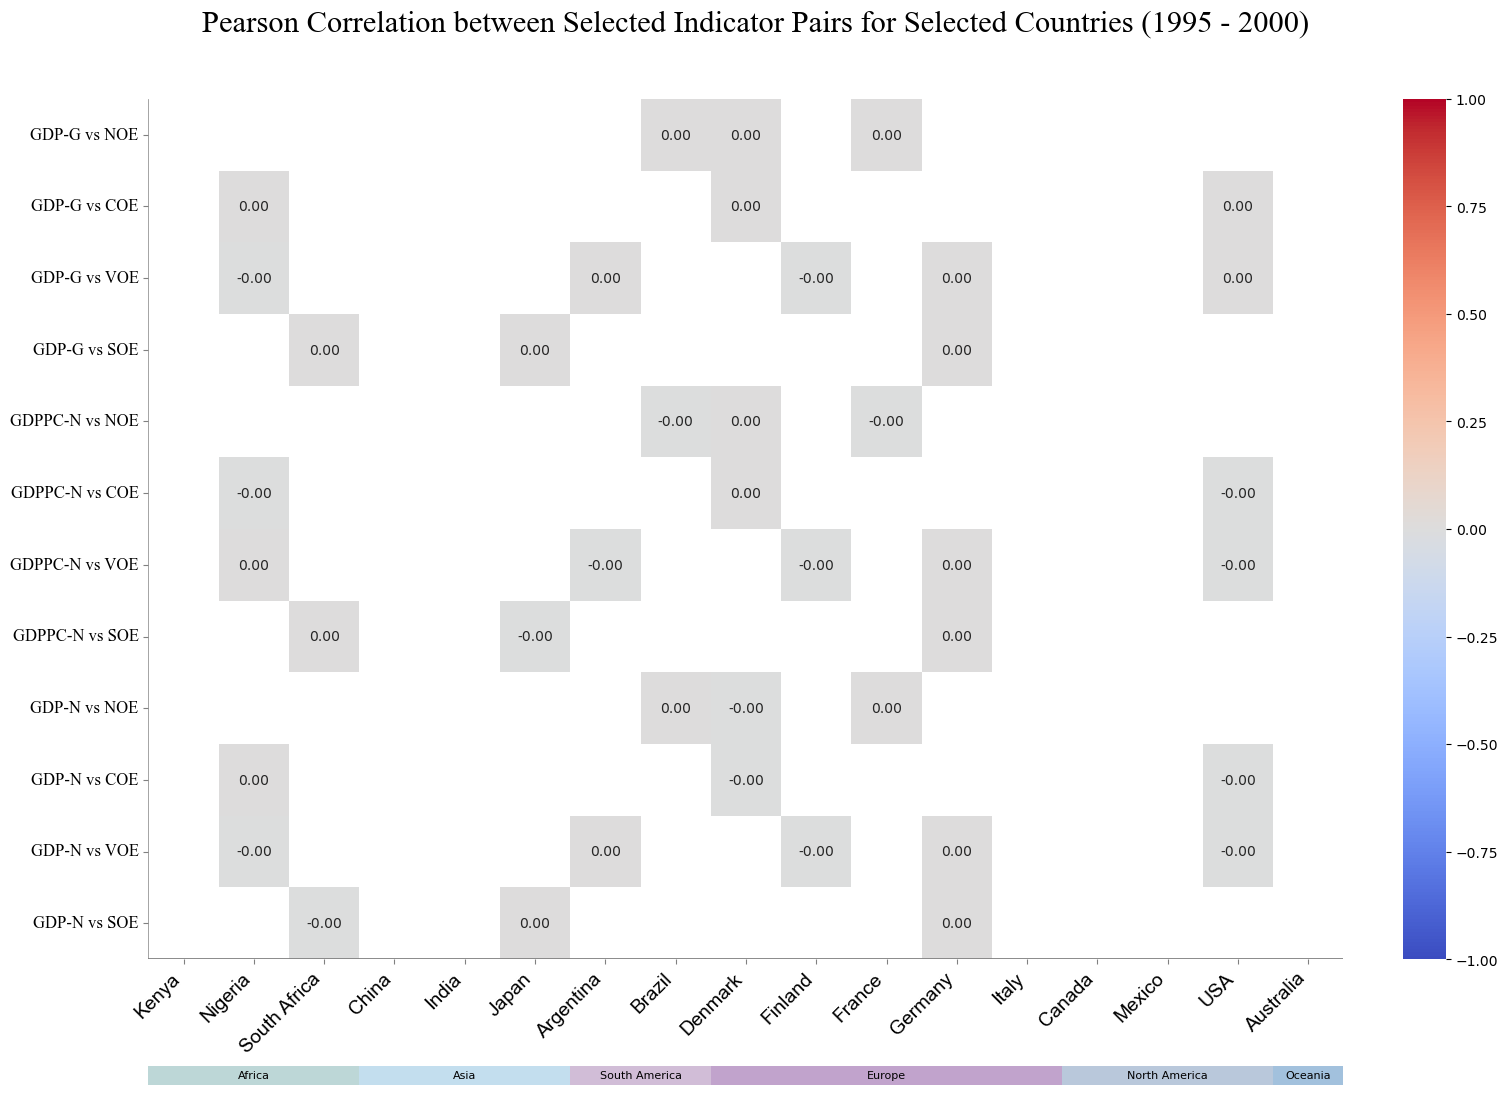

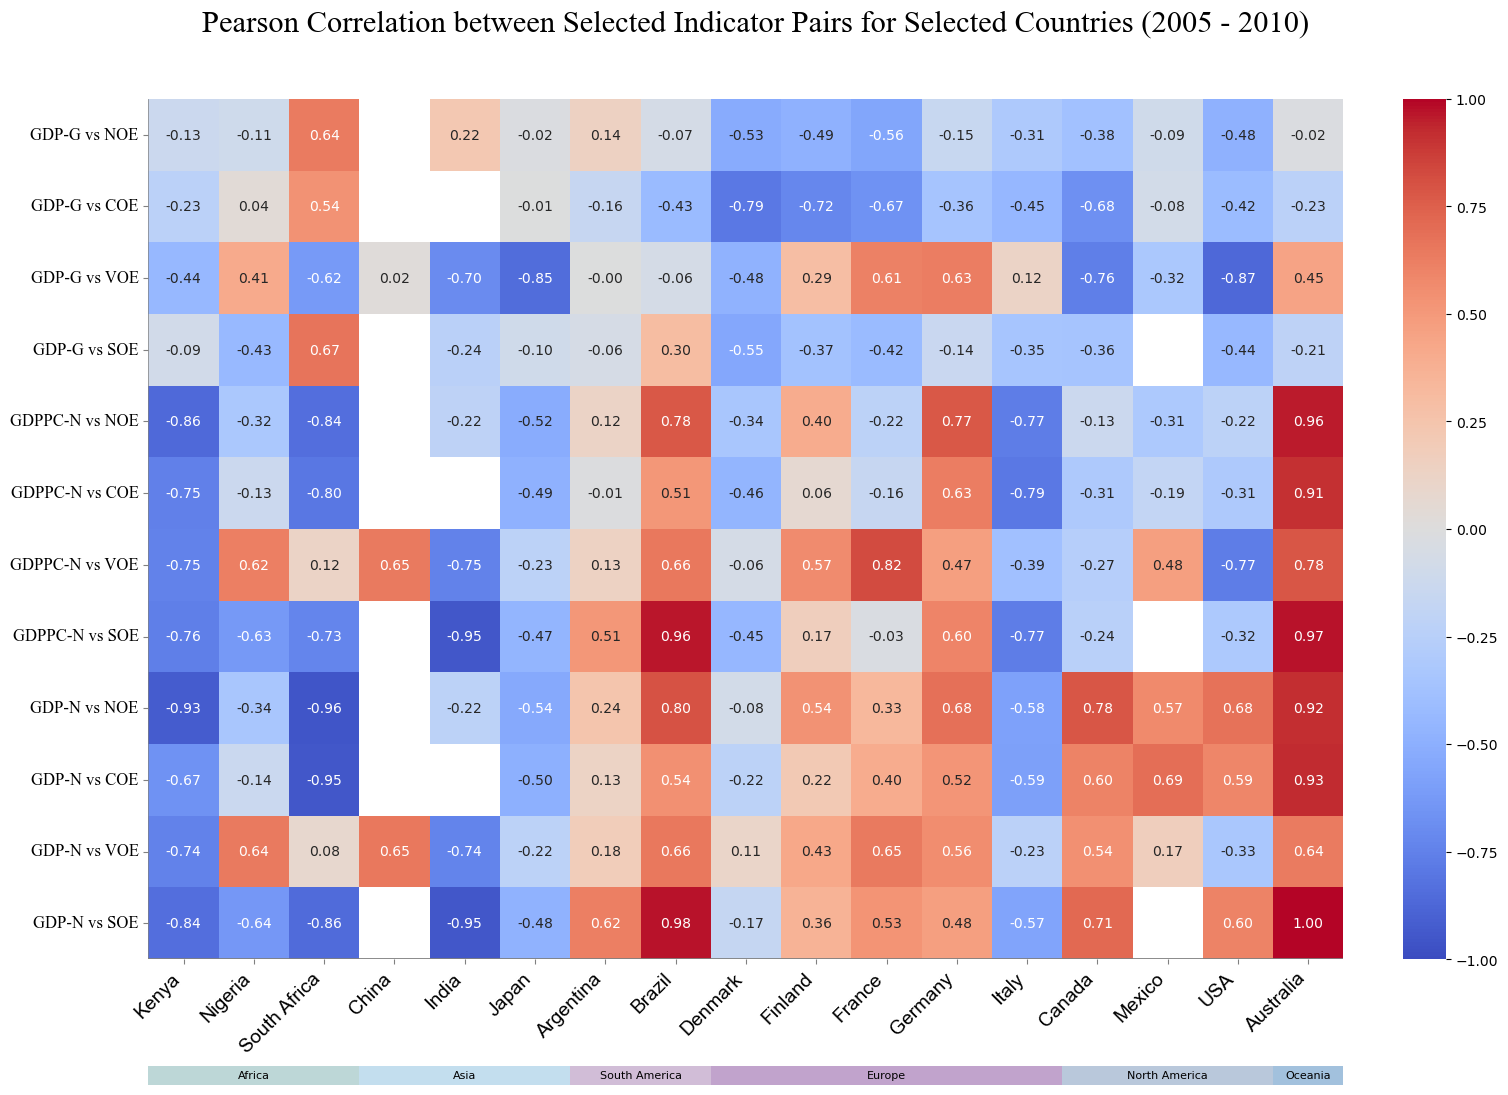

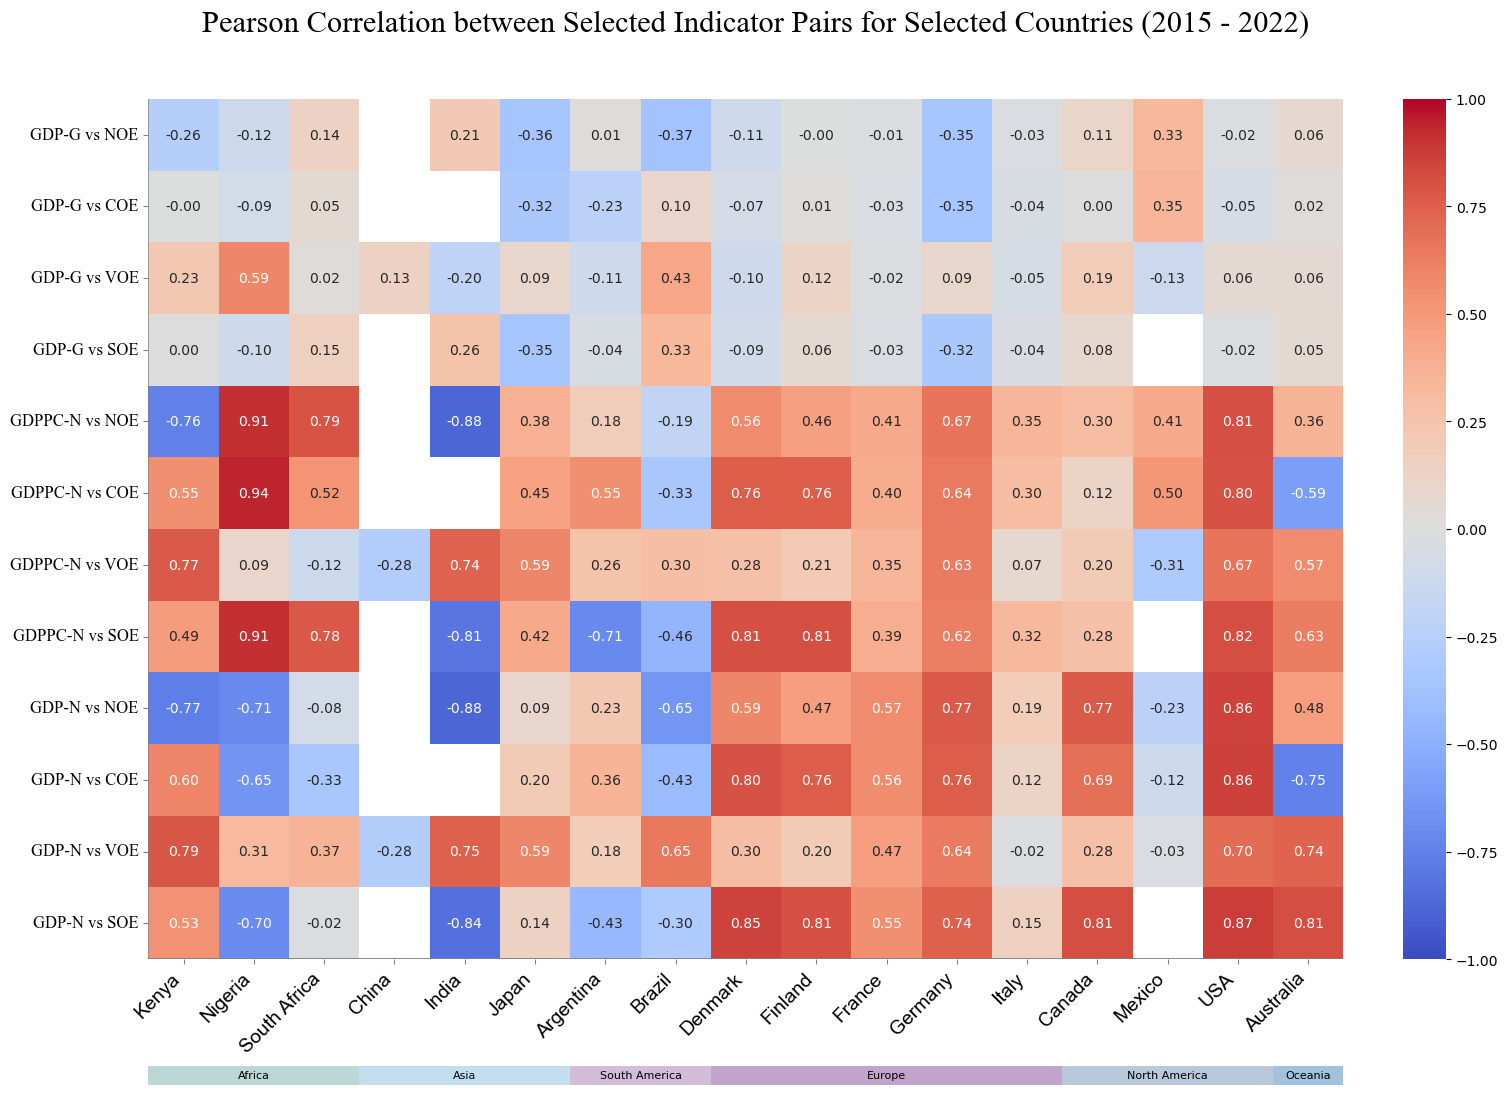

In [41]:
unique_countries = merged_data["country"].unique()
countries_with_continent = [(country, continent_dict[country])
                            for country in unique_countries]
sorted_countries = sorted(countries_with_continent,
                          key=lambda x: (continent_order.index(x[1]), x[0]))
sorted_country_names = [country for country, _ in sorted_countries]


def compute_window_correlation(data, indicator_pairs, year_start, year_end):
    data_window = data[(data["year"] >= year_start)
                       & (data["year"] <= year_end)]
    correlation_matrix = np.zeros(
        (len(indicator_pairs), len(sorted_country_names)))

    for i, (indicator1, indicator2) in enumerate(indicator_pairs):
        correlations = data_window.groupby("country").apply(
            lambda group: group[indicator1].corr(group[indicator2]))
        correlations = correlations.loc[sorted_country_names]
        correlation_matrix[i, :] = correlations.values
        correlation_df = pd.DataFrame(correlation_matrix, columns=sorted_country_names, index=[
                                      f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs])

    return correlation_df
                

def plot_single_heatmap(correlation_df, year_start, year_end):
    fig, (ax, ax_bar) = plt.subplots(2, 1, figsize=(
        15, 10), gridspec_kw={'height_ratios': [45, 1]}, constrained_layout=True)
    sns.heatmap(correlation_df, annot=True, fmt=".2f",
                cmap="coolwarm", cbar=True, vmin=-1, vmax=1, ax=ax)
    x_label_font = {'fontname': 'Arial', 'size': 14}
    ax.set_xticklabels(correlation_df.columns, rotation=45,
                       ha='right', fontdict=x_label_font)
    y_label_font = {'fontname': 'Times New Roman', 'size': 12}
    ax.set_yticklabels(correlation_df.index, rotation=0, fontdict=y_label_font)
    ax.invert_yaxis()
    ax.axhline(y=0, color='gray', linewidth=2)
    ax.axvline(x=0, color='gray', linewidth=0.5)
    ax.tick_params(axis='both', which='both', color='gray')
    title_font = {'fontname': 'Times New Roman','weight': 'bold'}
    fig.suptitle(f"Pearson Correlation between Selected Indicator Pairs for Selected Countries ({year_start} - {year_end})", y=1.08, fontdict=title_font, fontsize=22)



    xticks = ax.get_xticks()
    continent_boundaries = [0] + [(xticks[i] + xticks[i - 1])/2 for i in range(1, len(xticks)) if dict(countries_with_continent)[
        correlation_df.columns[i]] != dict(countries_with_continent)[correlation_df.columns[i - 1]]] + [xticks[-1] + 0.5]    

    for i in range(len(continent_order)):
        start_tick = continent_boundaries[i]
        end_tick = continent_boundaries[i + 1]
        continent = continent_order[i]
        color = continent_colors[continent]

        ax_bar.axvspan(start_tick, end_tick, ymin=0,
                       ymax=1, color=color, alpha=0.4, lw=0)
        ax_bar.text((start_tick + end_tick) / 2, 0.5, continent,
                    ha='center', va='center', fontsize=8)

    ax_bar.set_xlim(ax.get_xlim())
    ax_bar.set_ylim(0, 1)
    ax_bar.set_yticks([])
    ax_bar.set_xticks([])
    ax_bar.spines['top'].set_visible(False)
    ax_bar.spines['right'].set_visible(False)
    ax_bar.spines['left'].set_visible(False)
    ax_bar.spines['bottom'].set_visible(False)

    
    plt.savefig(
        f"Pearson Correlation between Selected Indicator Pairs for Selected Countries ({year_start} - {year_end})", dpi=800, bbox_inches='tight')
    plt.show()


for year_start, year_end in custom_windows:
    correlation_df = compute_window_correlation(
        merged_data, indicator_pairs_1, year_start, year_end)
    plot_single_heatmap(correlation_df, year_start, year_end)


<span style="font-size:20pt;">Plotting Pearson Correlation of `indicator_pairs_1` for Selected Countries in Three Time Windows - Country</span>

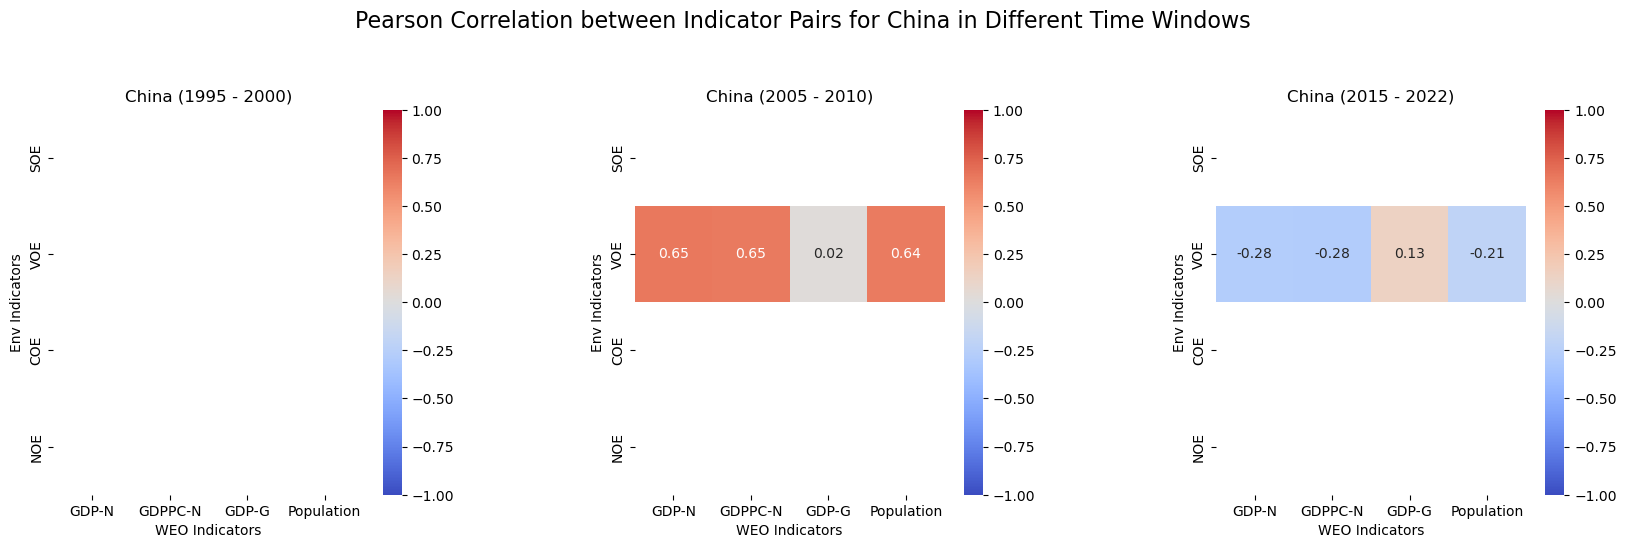

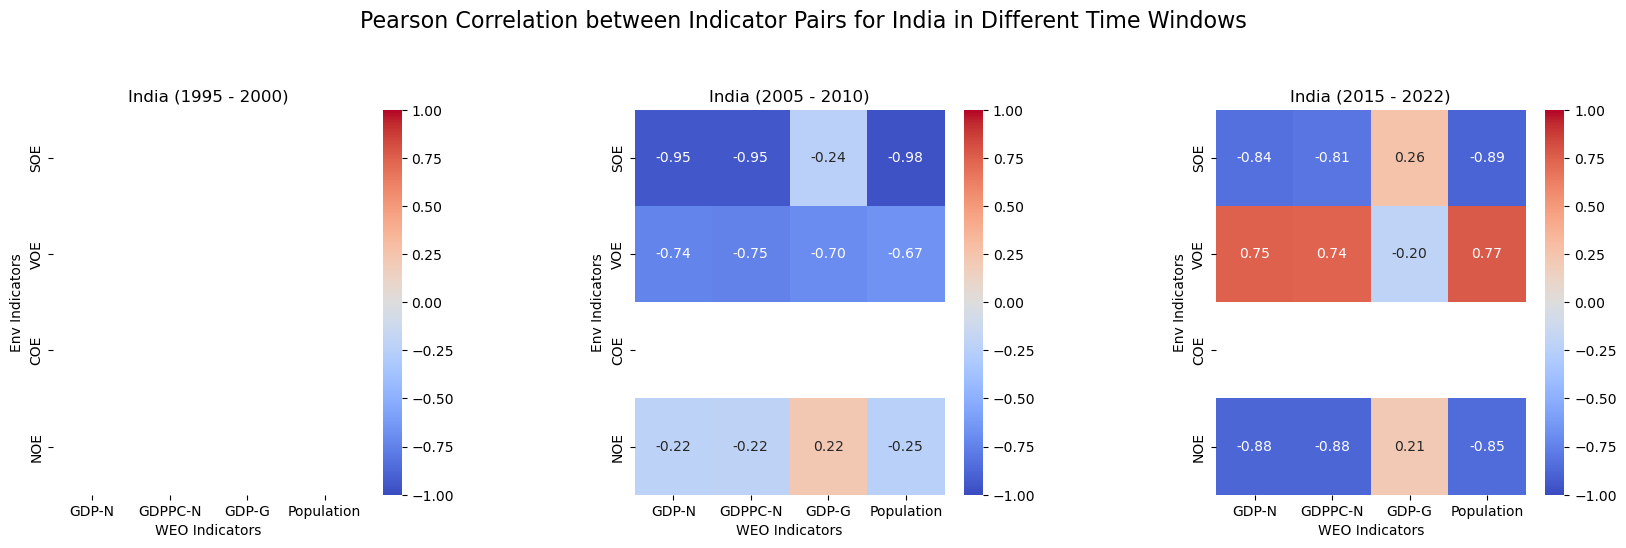

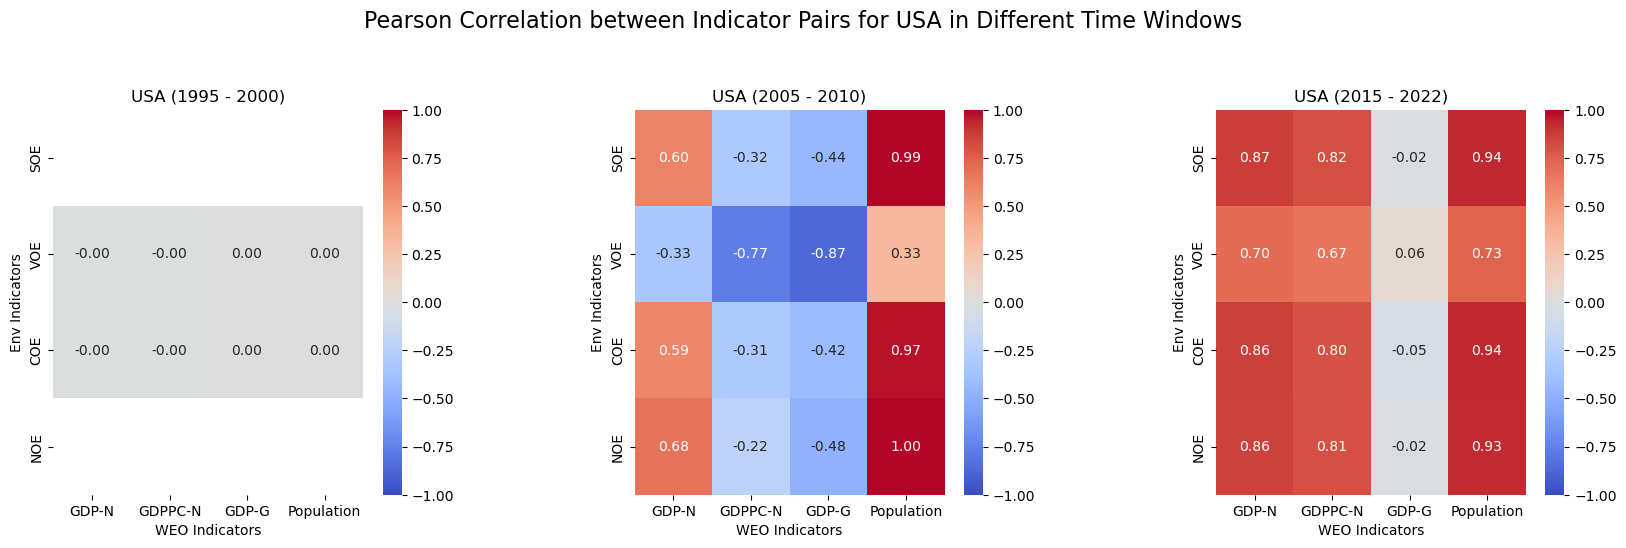

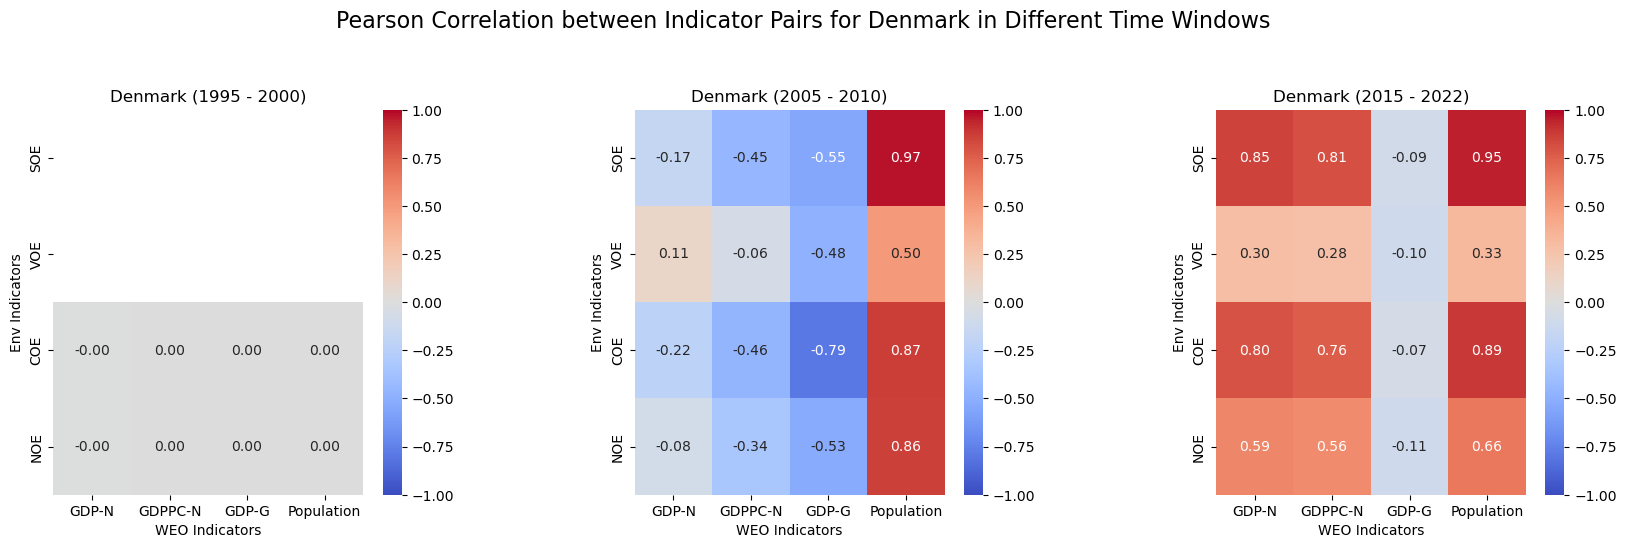

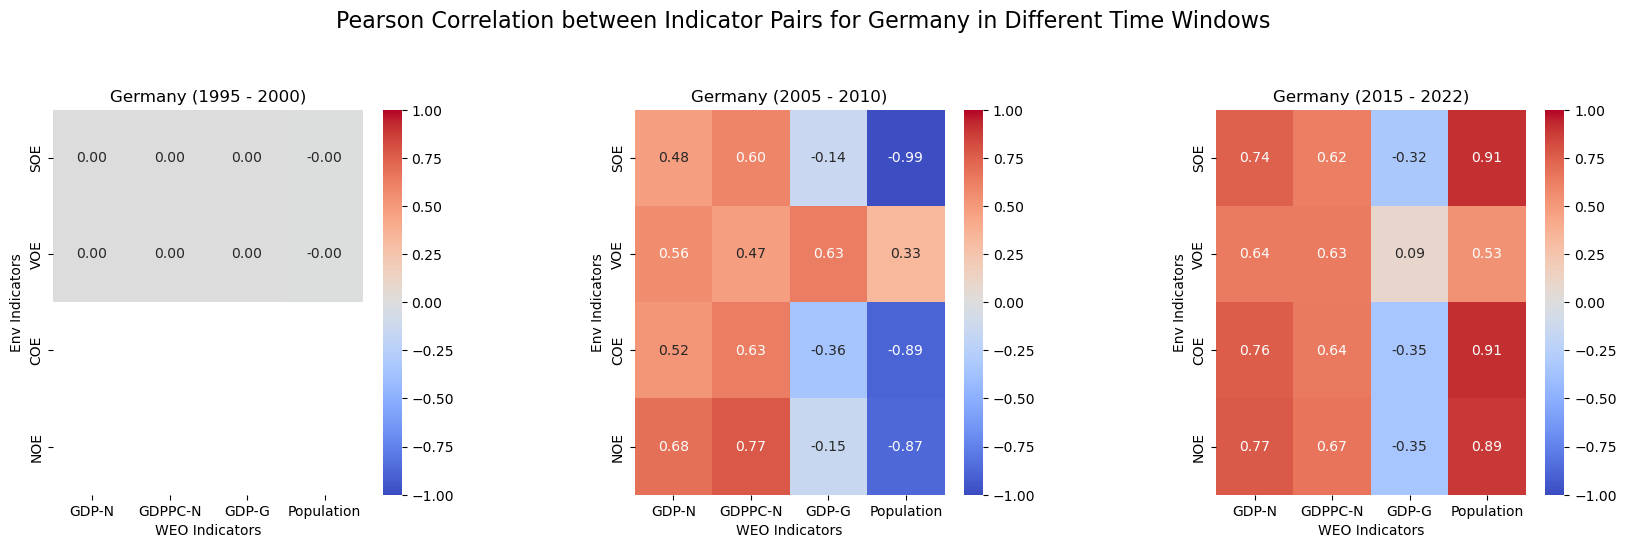

In [42]:
def plot_correlation_heatmap(data, country, custom_windows, env_indicators, weo_indicators):
    fig, axes = plt.subplots(nrows=1, ncols=len(
        custom_windows), figsize=(20, 5))
    plt.subplots_adjust(wspace=0.5)

    for i, (year_start, year_end) in enumerate(custom_windows):
        data_window = data[(data["year"] >= year_start) & (
            data["year"] <= year_end) & (data["country"] == country)]
        correlation_df = pd.DataFrame(
            index=env_indicators, columns=weo_indicators)

        for indicator1 in env_indicators:
            for indicator2 in weo_indicators:
                correlation = data_window[indicator1].corr(
                    data_window[indicator2])
                correlation_df.loc[indicator1, indicator2] = correlation
                
        correlation_df = correlation_df.astype(float)

        ax = axes[i]
        sns.heatmap(correlation_df, annot=True, fmt=".2f",
                    cmap="coolwarm", cbar=True, vmin=-1, vmax=1, ax=ax)
        ax.set_title(f"{country} ({year_start} - {year_end})")
        ax.set_xlabel("WEO Indicators")
        ax.set_ylabel("Env Indicators")

    plt.suptitle(
        f"Pearson Correlation between Indicator Pairs for {country} in Different Time Windows", y=1.08, fontsize=16)
    plt.savefig(
        f"Pearson Correlation between Indicator Pairs for {country} in Different Time Windows", dpi=800, bbox_inches='tight')
    plt.show()

for country in selected_countries:
    plot_correlation_heatmap(merged_data, country,
                             custom_windows, env_2, weo_2)

<span style="font-size:20pt;">Plotting Pearson Correlation of `indicator_pairs_2` for Main Continents Over Time</span>

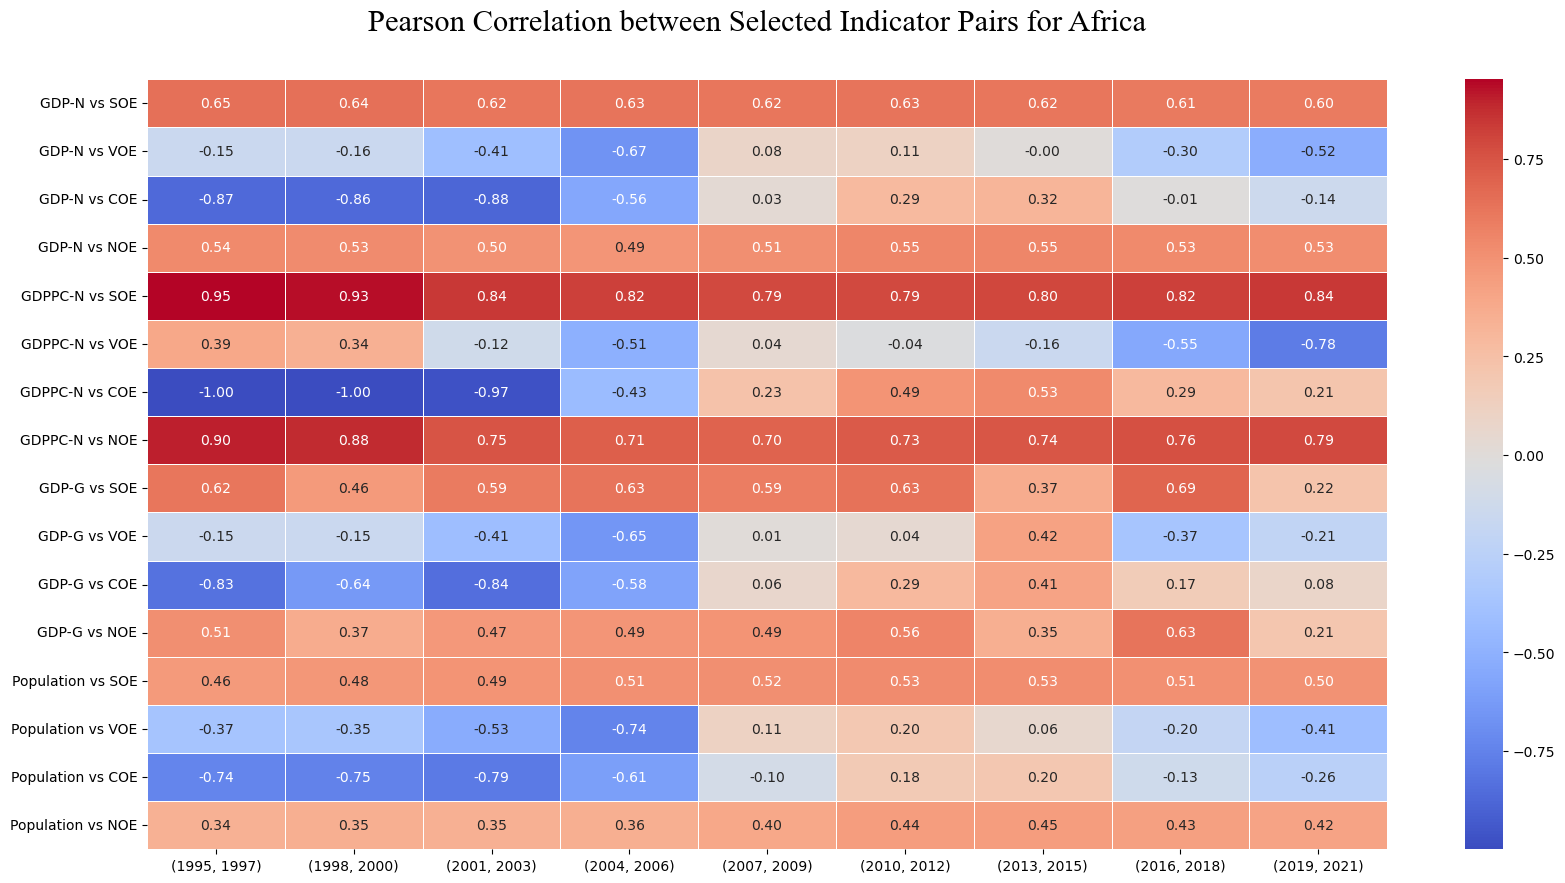

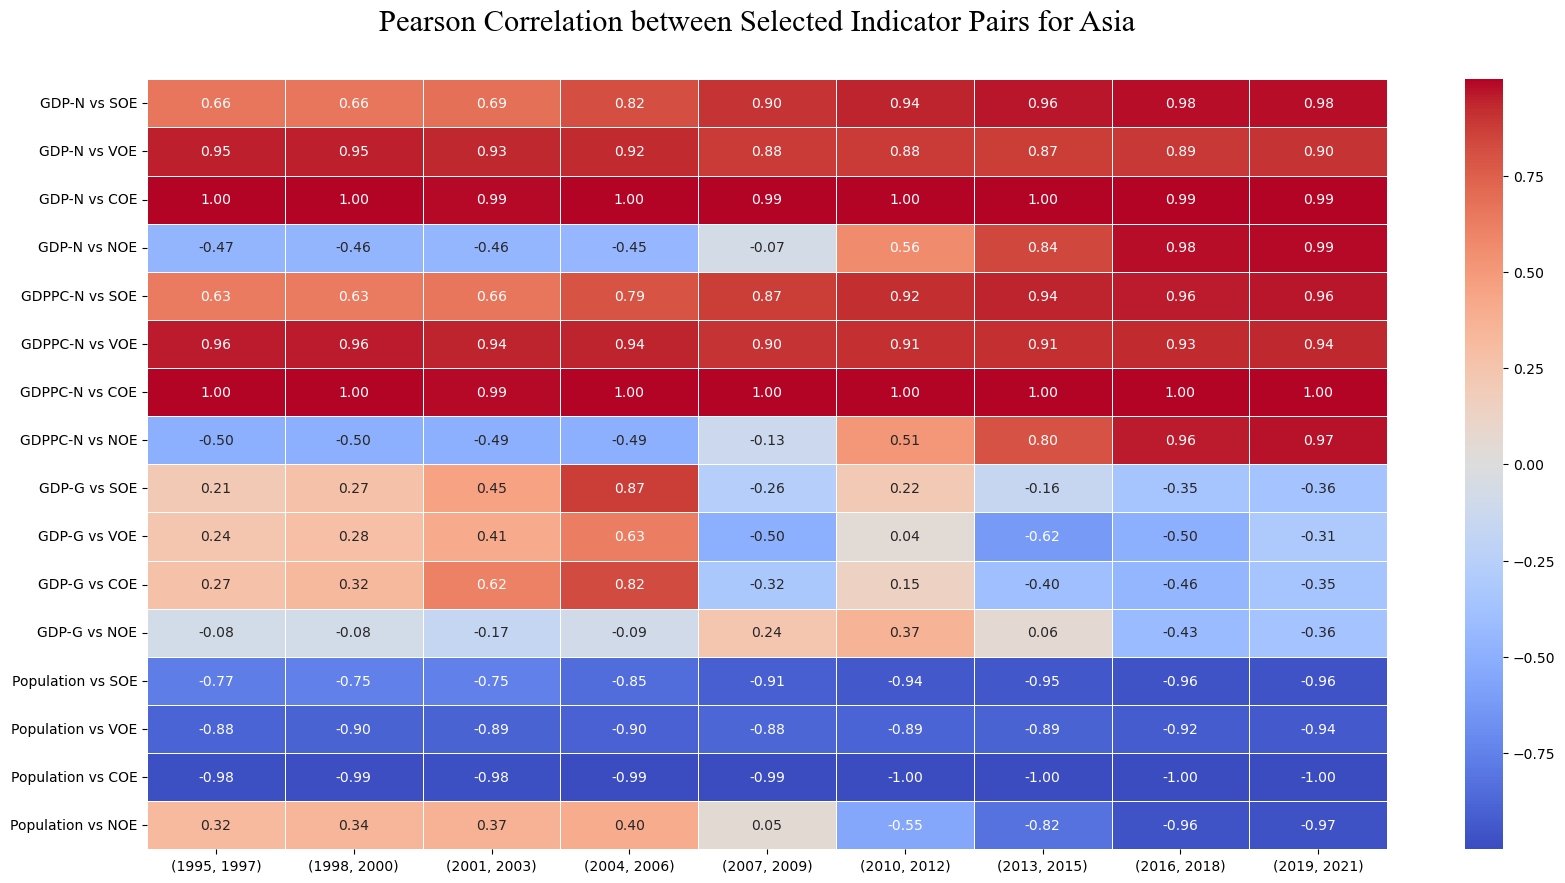

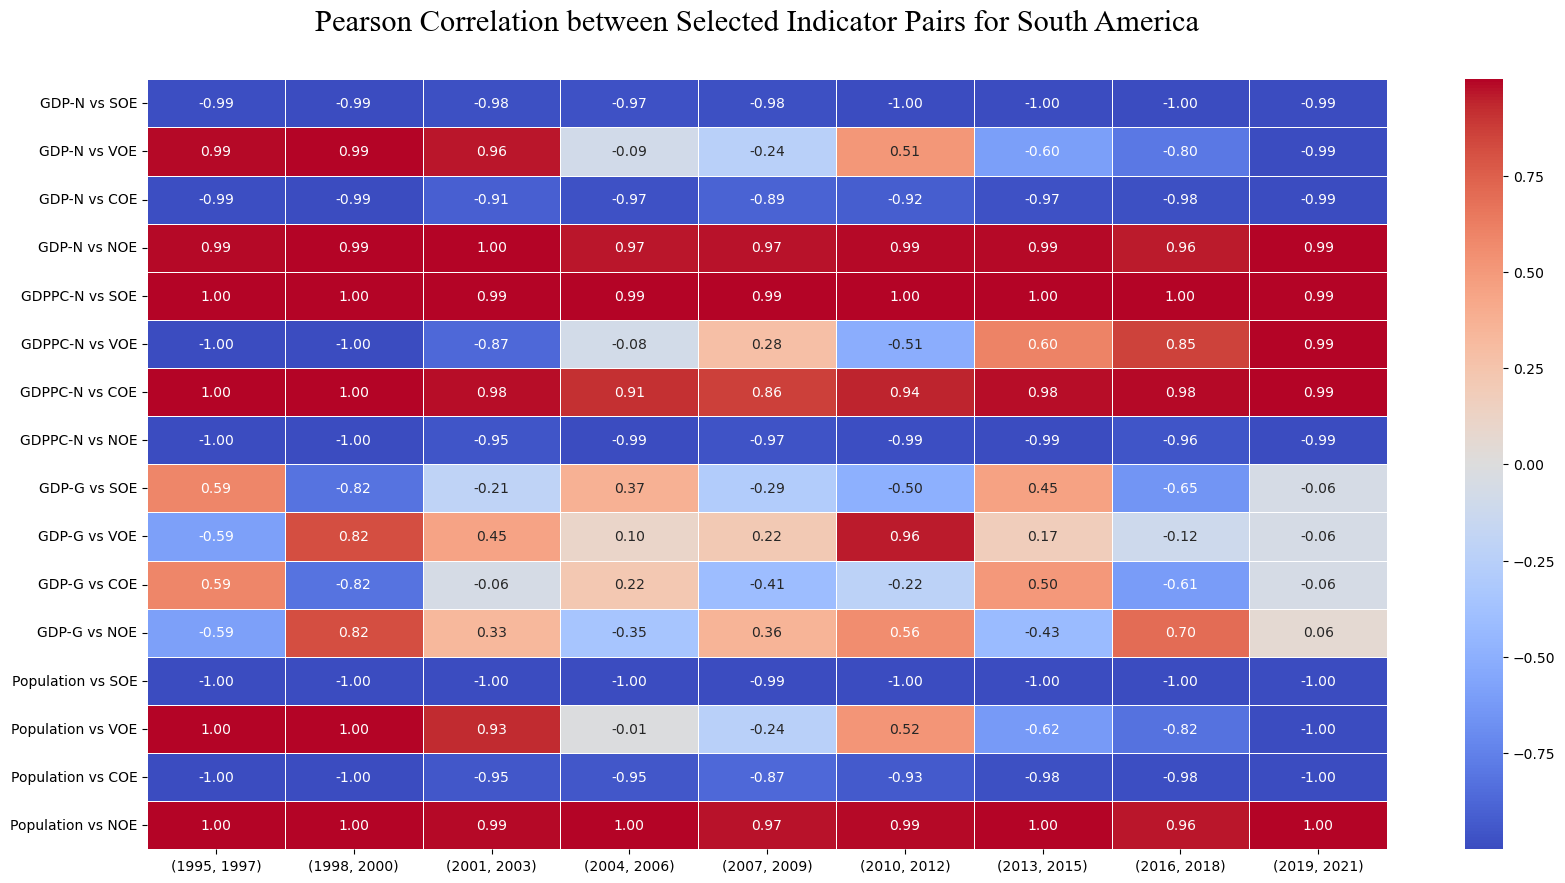

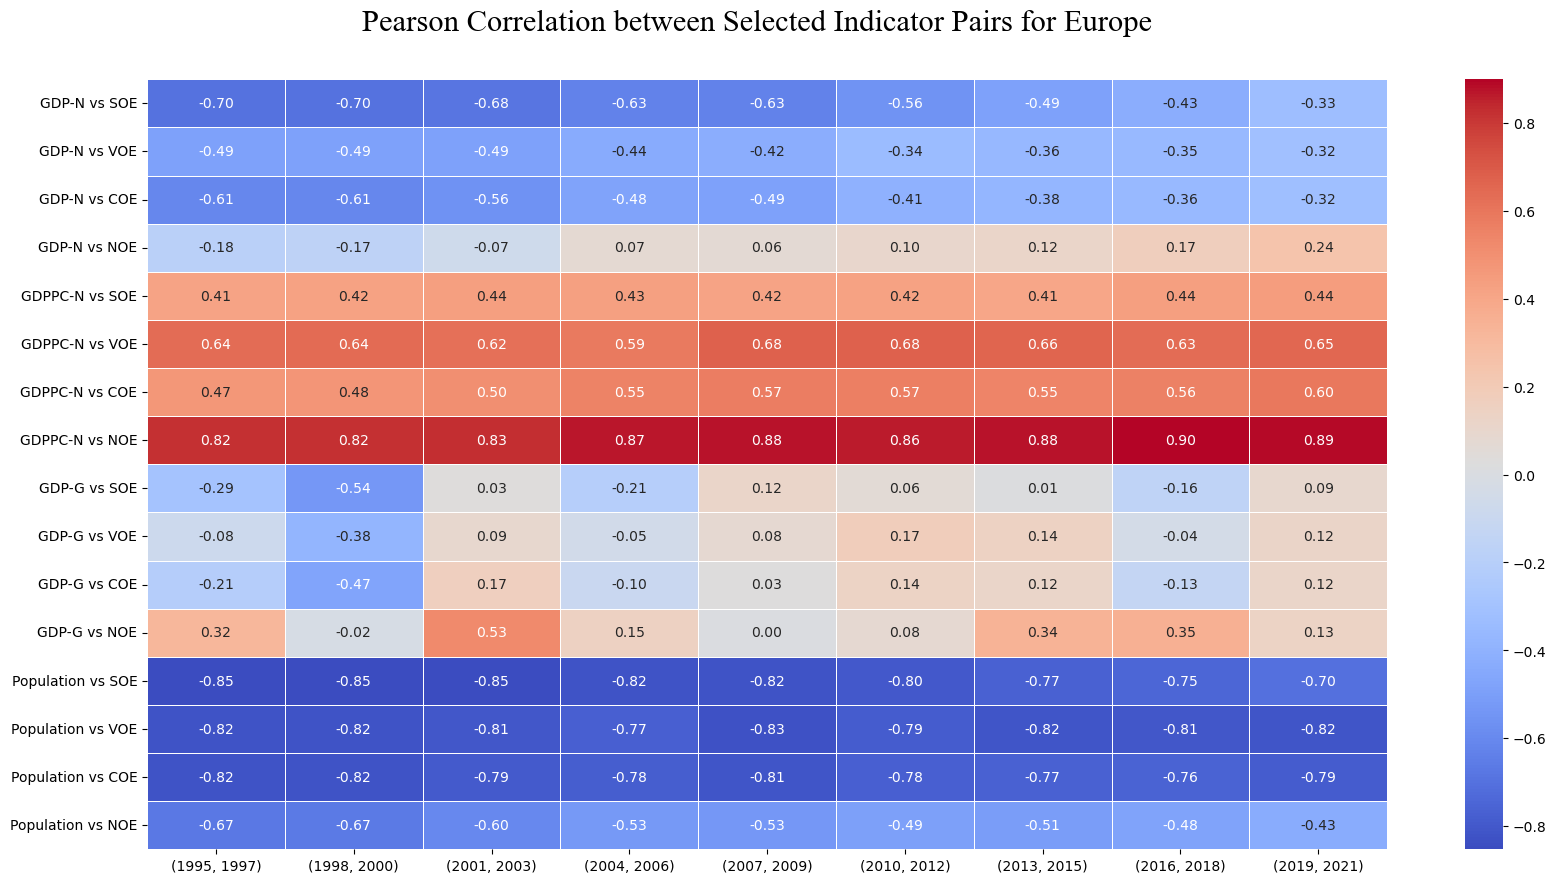

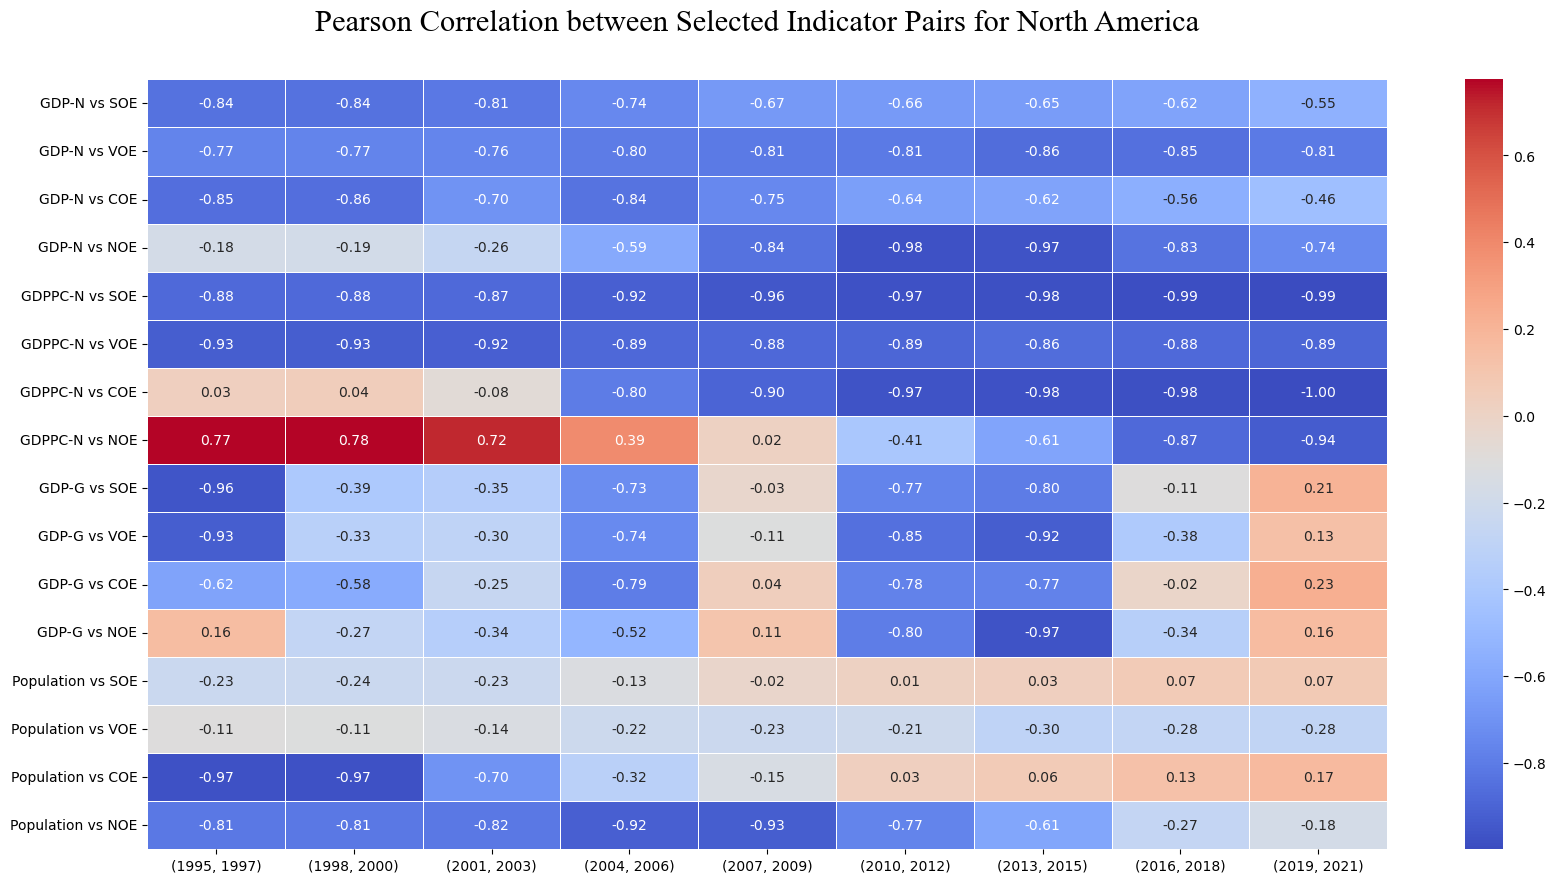

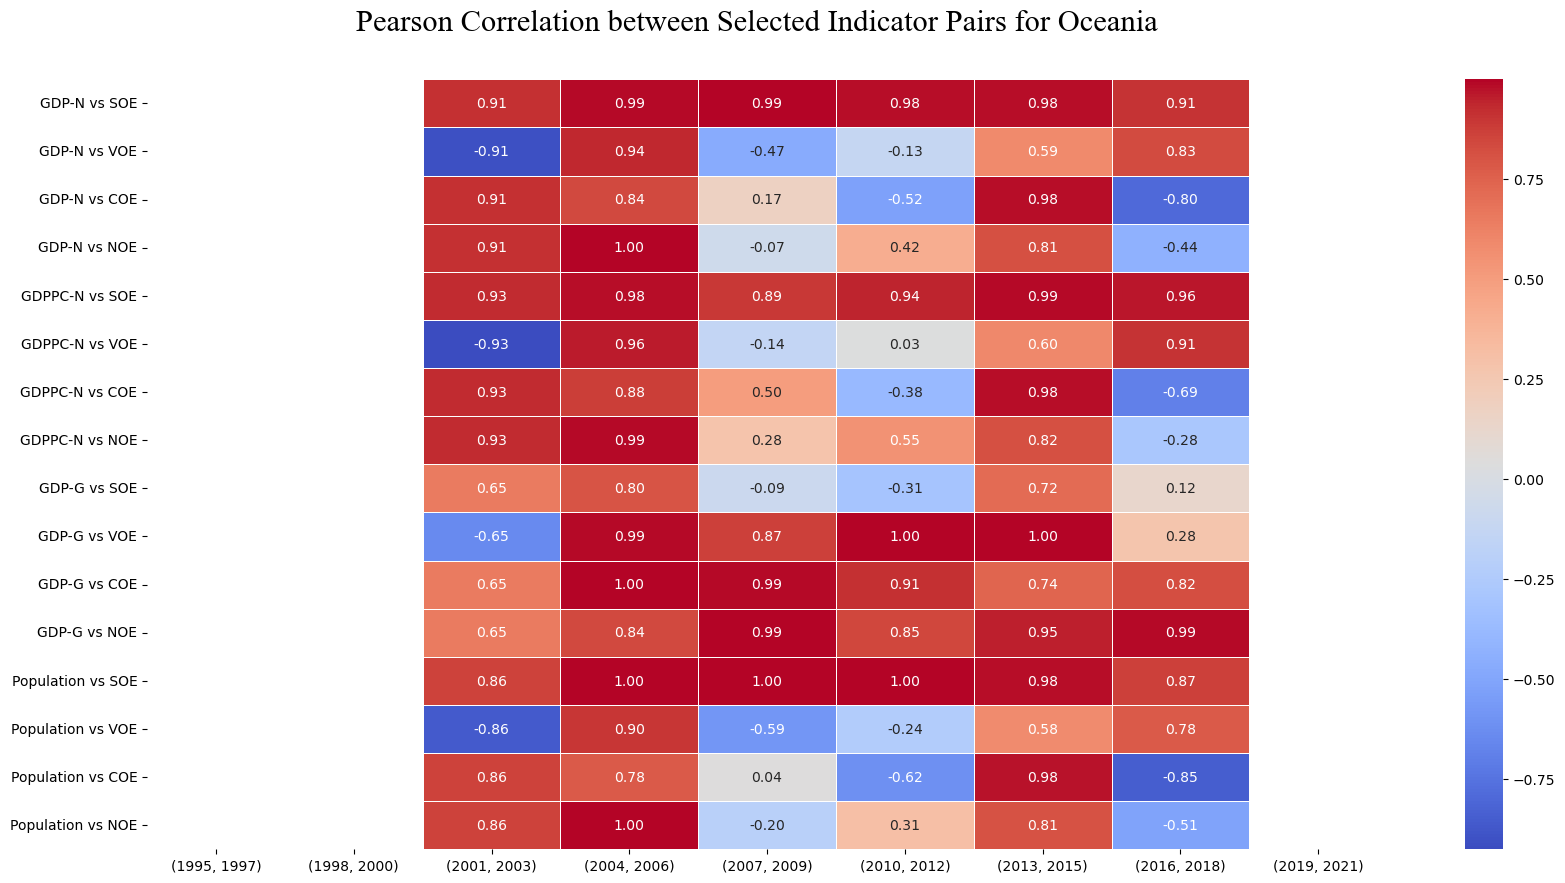

In [43]:
def get_continent_data(data, continent_dict):
    continent_data = data.copy()
    continent_data['continent'] = continent_data['country'].map(continent_dict)
    return continent_data

def plot_continent_heatmap(continent, continent_data, indicator_pairs):
    continent_data = continent_data[continent_data["continent"] == continent]
    years = sorted(continent_data['year'].unique())
    year_intervals = []
    start_year = years[0]
    for year in years[1:]:
        if (year - start_year) == 2:
            year_intervals.append((start_year, year))
            start_year = year + 1
        elif (year - start_year) == 1 and year == years[-1]:
            year_intervals[-1] = (year_intervals[-1][0], year)
        elif (year - start_year) == 0:
            start_year = year

    correlation_matrix = np.zeros((len(indicator_pairs), len(year_intervals)))
    year_grouped = continent_data.groupby(pd.cut(continent_data['year'], bins=[
                                          interval[0] for interval in year_intervals] + [year_intervals[-1][1]]))

    for i, (indicator1, indicator2) in enumerate(indicator_pairs):
        correlations = year_grouped.apply(
            lambda group: group[indicator1].corr(group[indicator2]))
        correlation_matrix[i, :] = correlations.values
    correlation_df = pd.DataFrame(correlation_matrix, columns=year_intervals,
                                  index=[f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs])
    plt.figure(figsize=(20, 10))
    sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True, fmt=".2f")
    title_font = {'fontname': 'Times New Roman', 'weight': 'bold'}
    plt.suptitle(
        f"Pearson Correlation between Selected Indicator Pairs for {continent}", y=0.95, fontdict=title_font, fontsize=22, x=0.43, ha='center')
    plt.savefig(
        f"Pearson Correlation between Selected Indicator Pairs for {continent}", dpi=800, bbox_inches='tight')
    plt.show()


selected_countries = list(continent_dict.keys())
filtered_data = merged_data[merged_data['country'].isin(selected_countries)]
continent_data = get_continent_data(filtered_data, continent_dict)

for continent in continent_order:
    plot_continent_heatmap(continent, continent_data, indicator_pairs_2)

<span style="font-size:20pt;">Other Exploration</span>

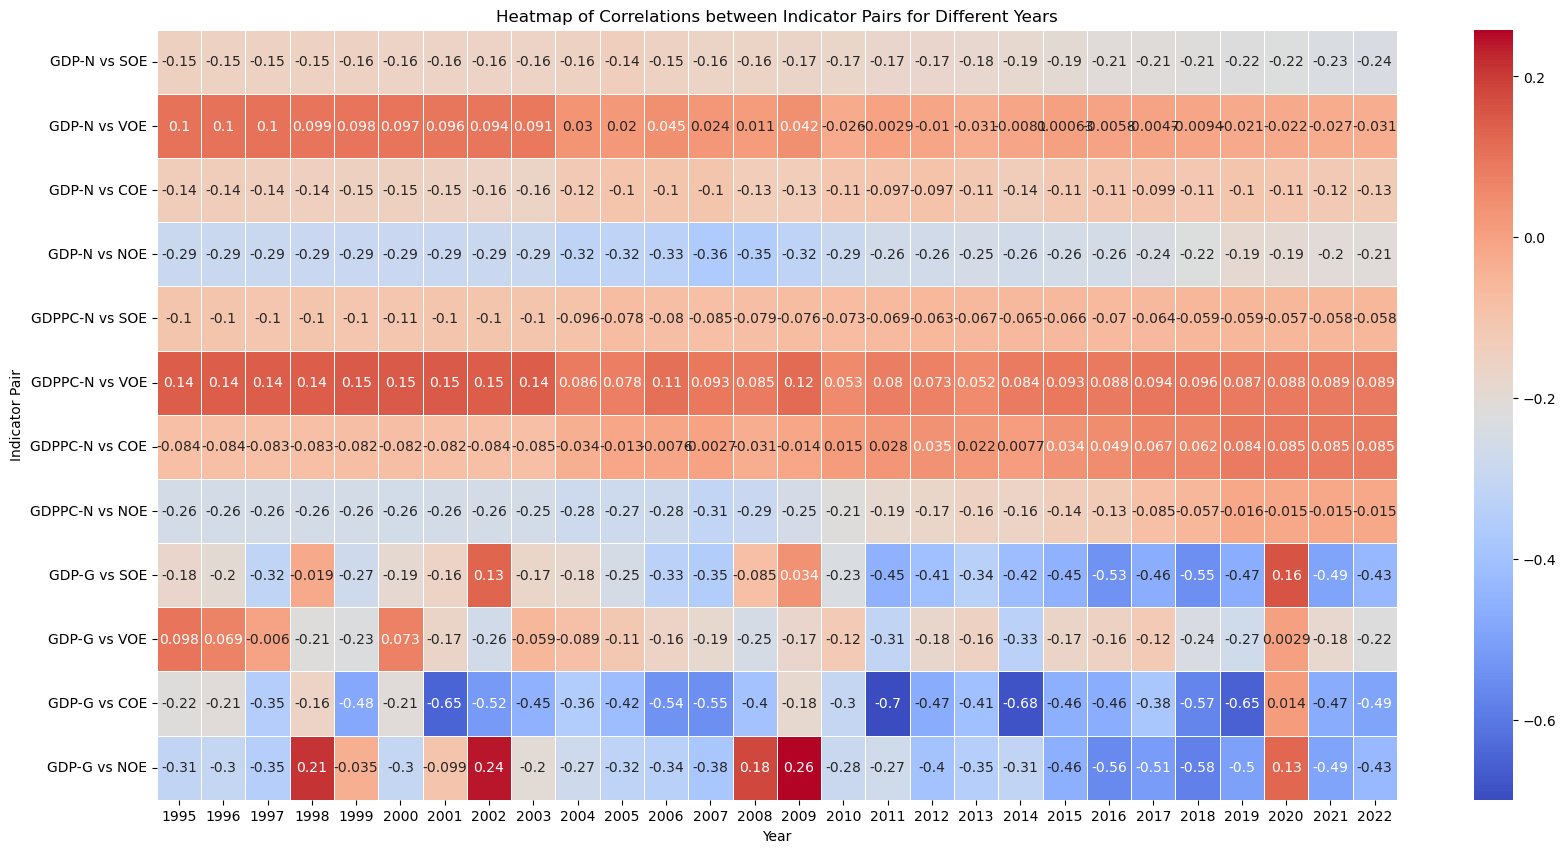

In [47]:
correlation_matrix = np.zeros((len(indicator_pairs_1), len(merged_data['year'].unique())))
for i, (indicator1, indicator2) in enumerate(indicator_pairs_1):
    correlations = merged_data.groupby("year").apply(lambda group: group[indicator1].corr(group[indicator2]))
    correlation_matrix[i, :] = correlations.values

correlation_df = pd.DataFrame(correlation_matrix, columns=merged_data['year'].unique(), index=[f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs_1])

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True)
plt.title('Heatmap of Correlations between Indicator Pairs for Different Years')
plt.xlabel('Year')
plt.ylabel('Indicator Pair')
plt.show()

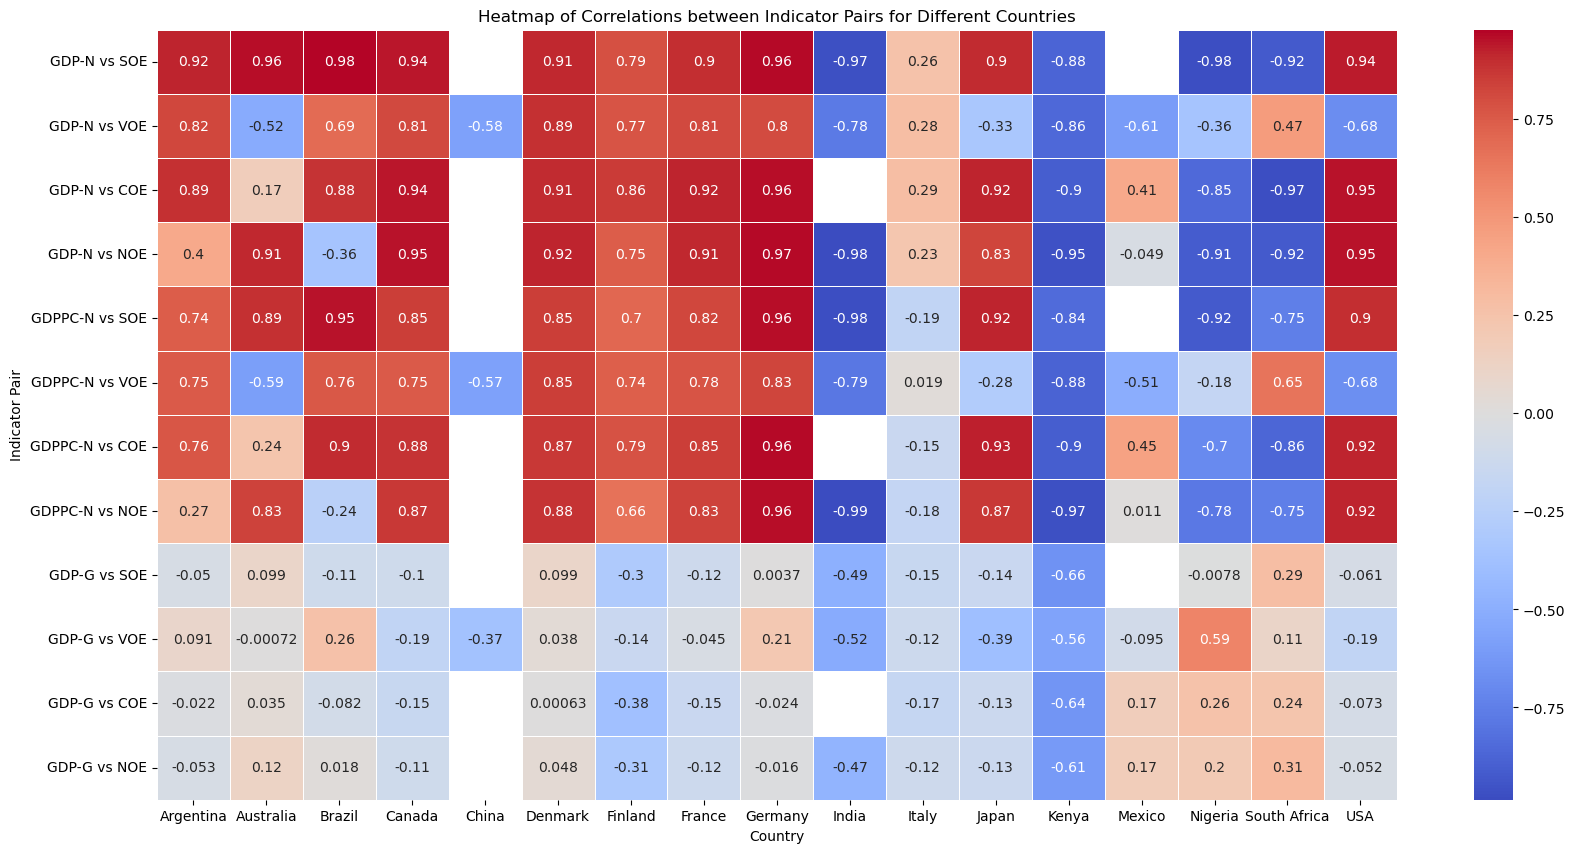

In [48]:
correlation_matrix = np.zeros((len(indicator_pairs_1), len(merged_data['country'].unique())))
for i, (indicator1, indicator2) in enumerate(indicator_pairs_1):
    correlations = merged_data.groupby("country").apply(lambda group: group[indicator1].corr(group[indicator2]))
    correlation_matrix[i, :] = correlations.values

correlation_df = pd.DataFrame(correlation_matrix, columns=merged_data['country'].unique(), index=[f"{pair[0]} vs {pair[1]}" for pair in indicator_pairs_1])

plt.figure(figsize=(20, 10))
sns.heatmap(correlation_df, cmap='coolwarm', linewidths=0.5, annot=True)
plt.title('Heatmap of Correlations between Indicator Pairs for Different Countries')
plt.xlabel('Country')
plt.ylabel('Indicator Pair')
plt.show()

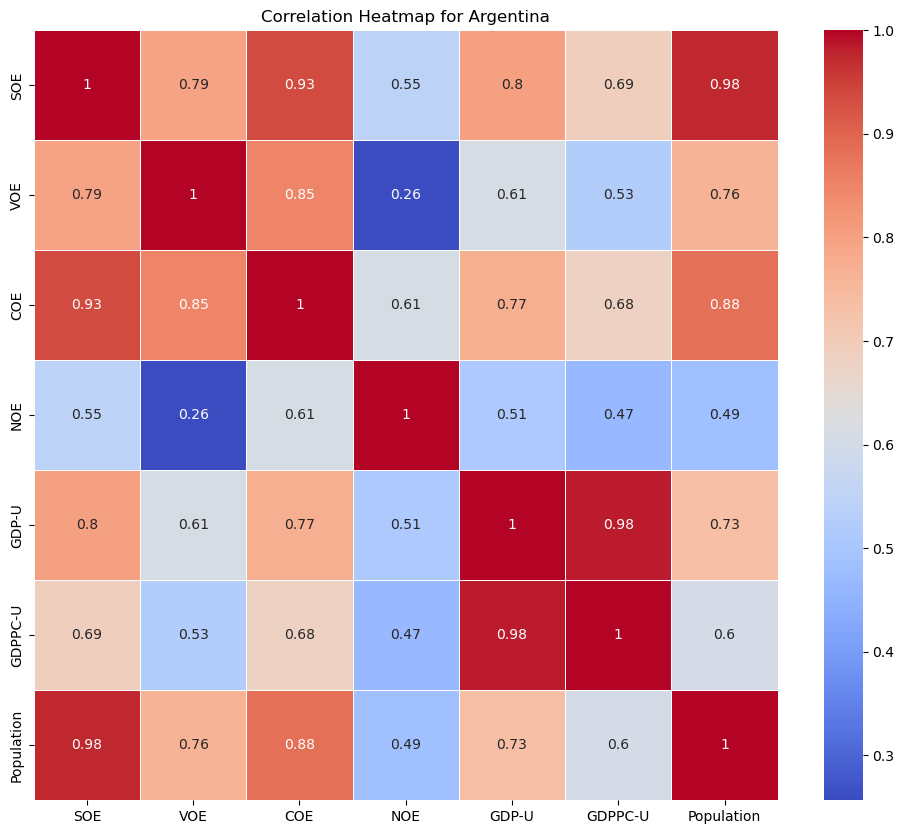

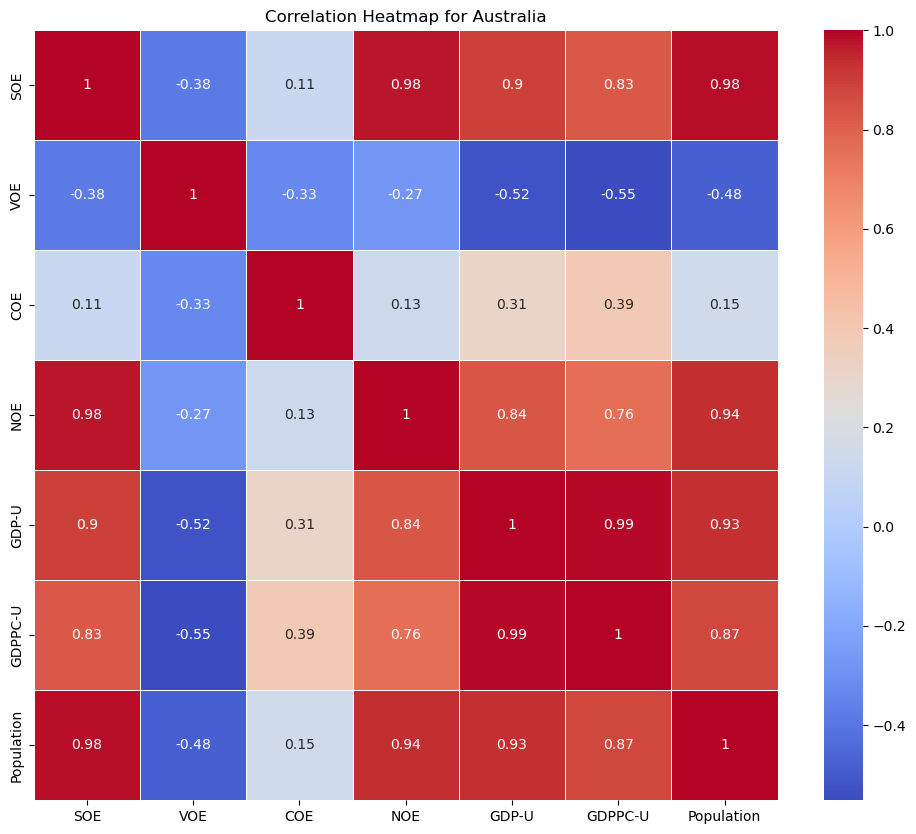

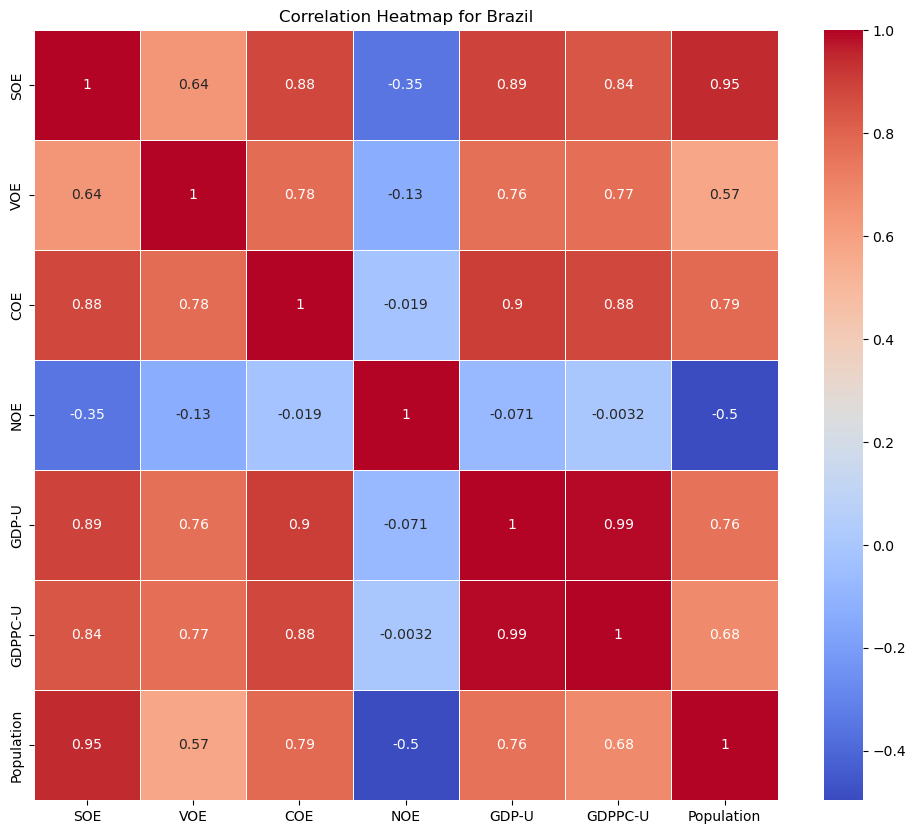

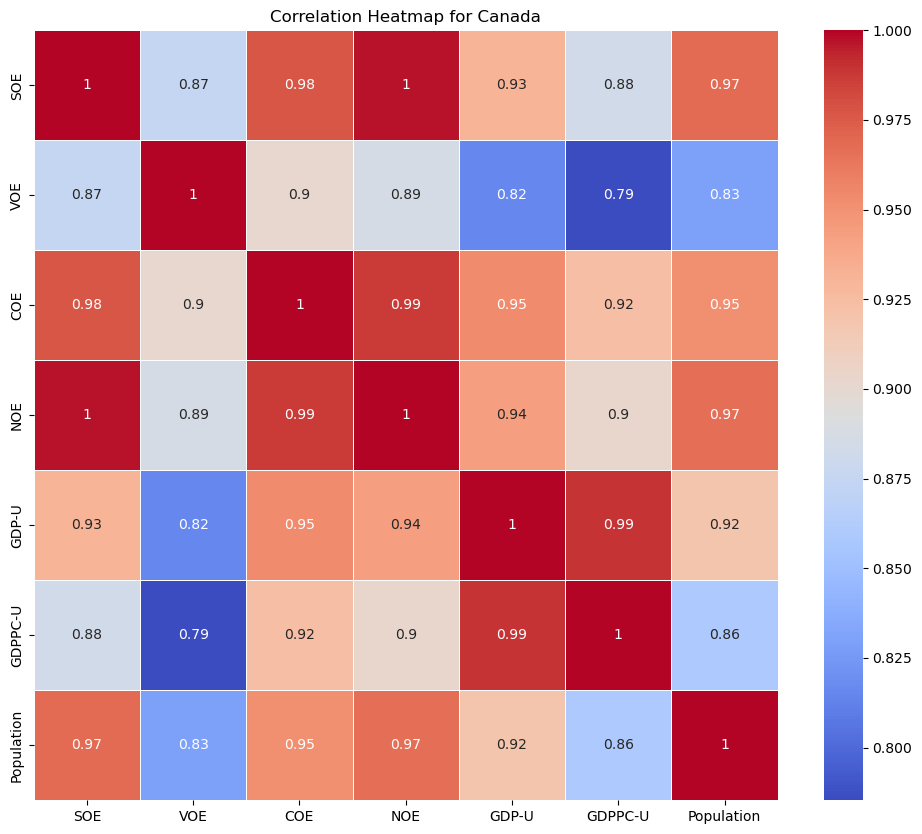

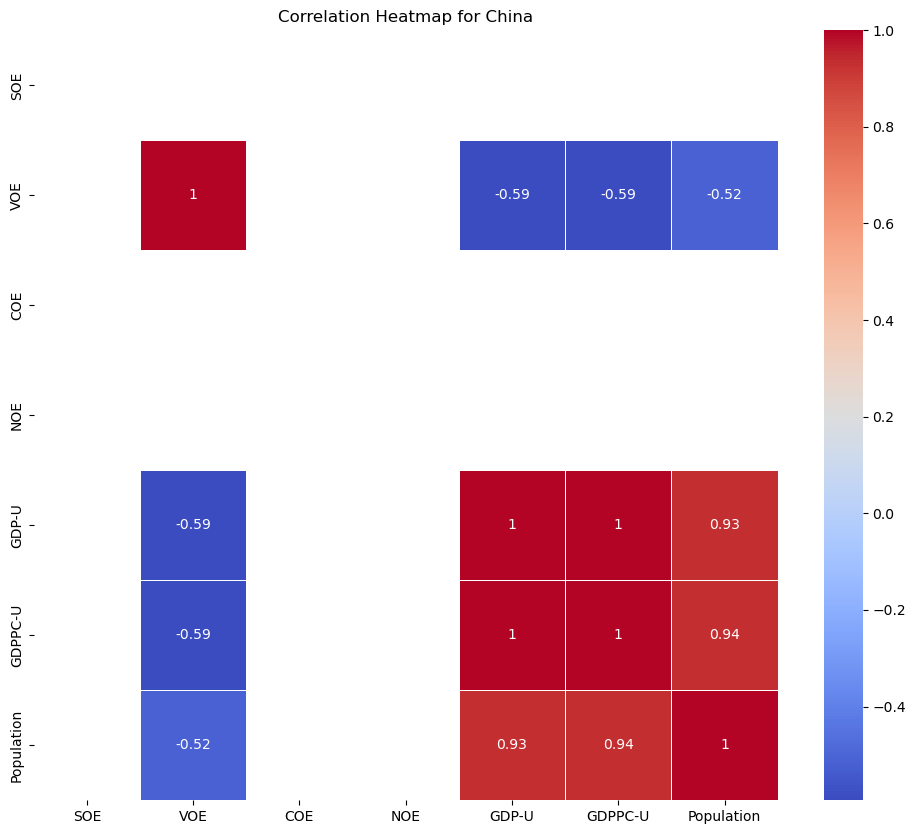

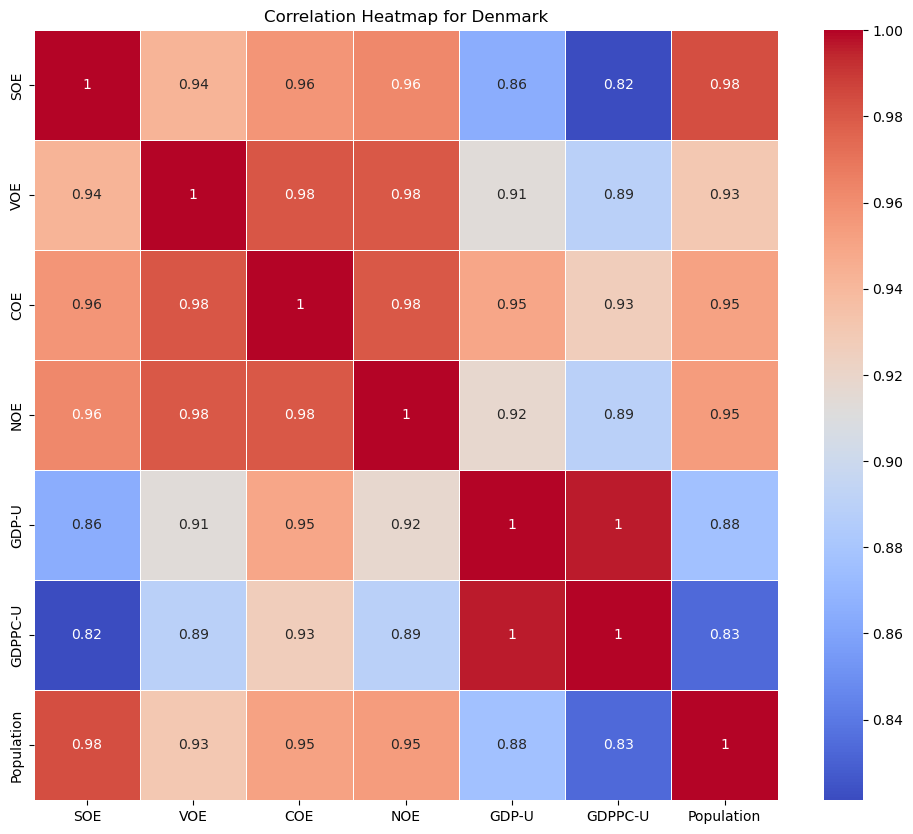

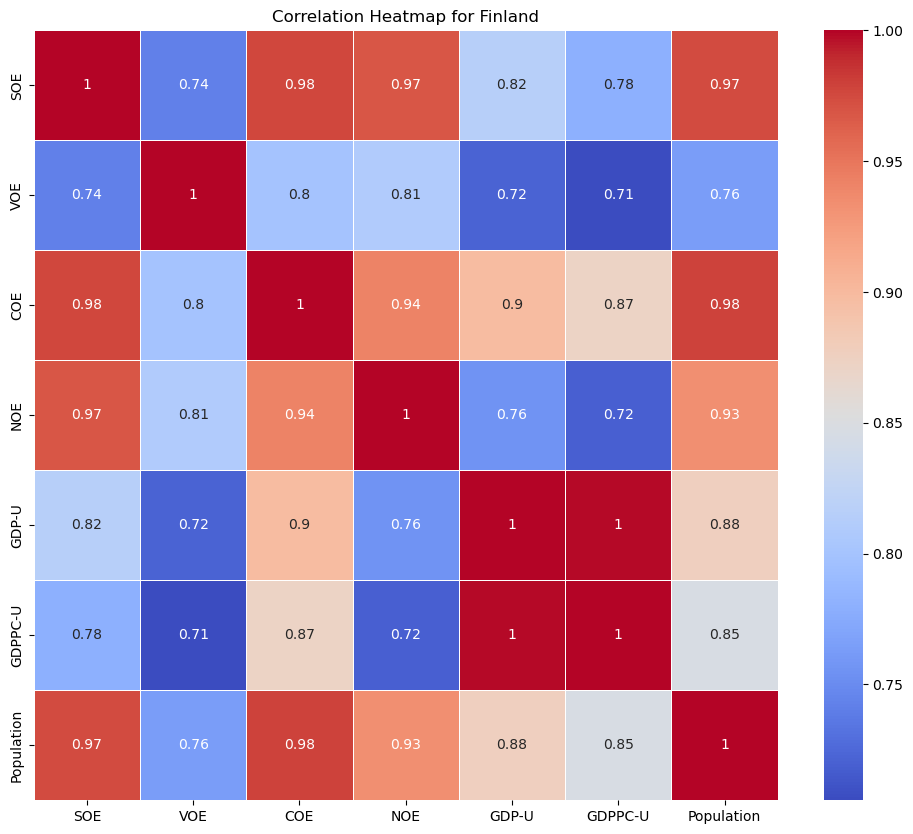

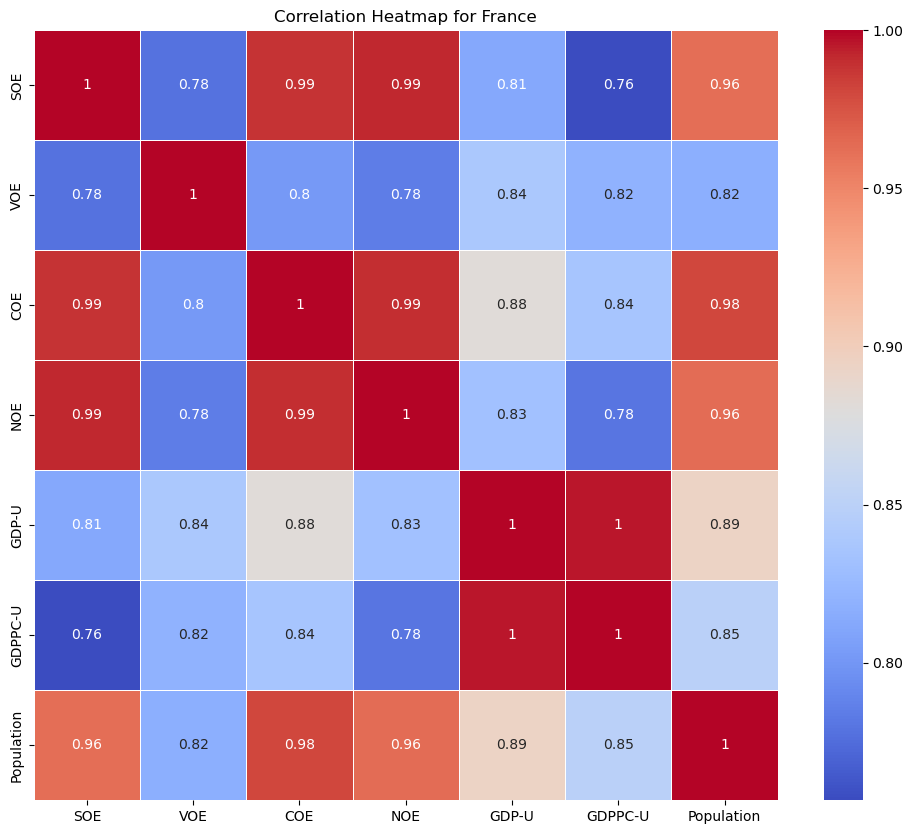

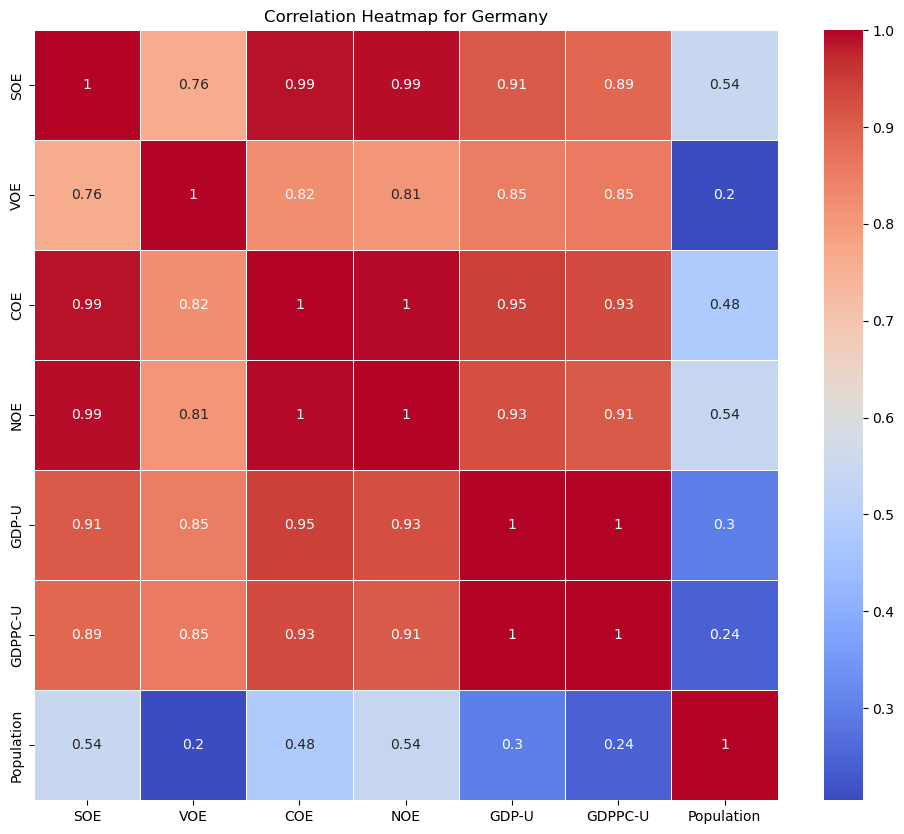

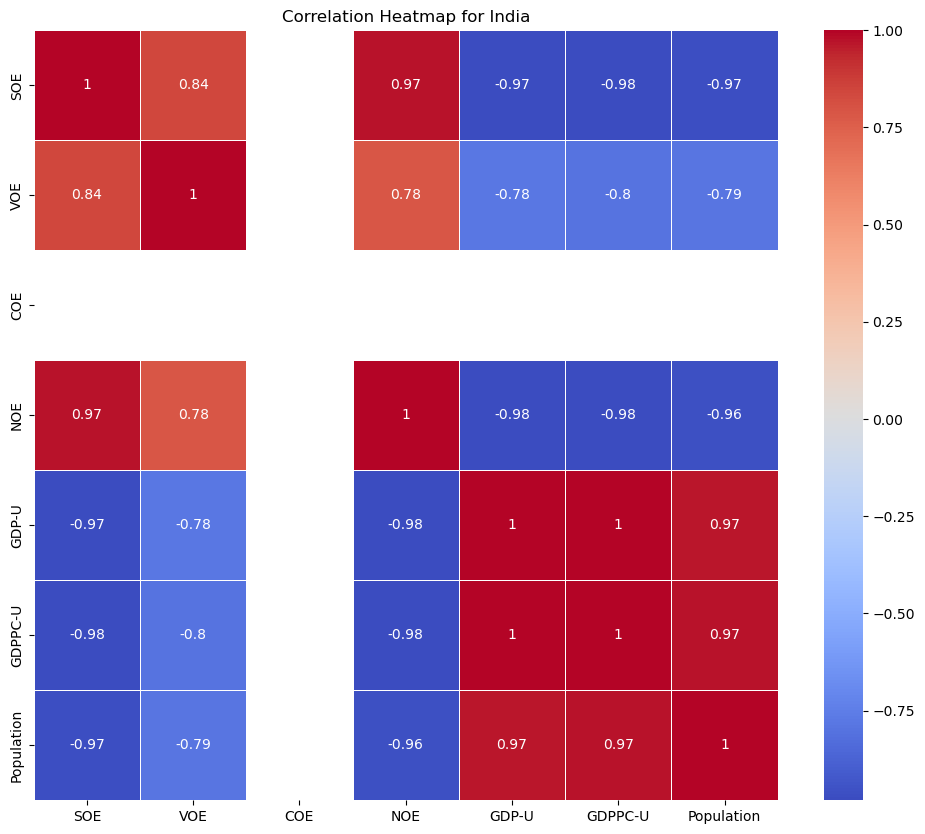

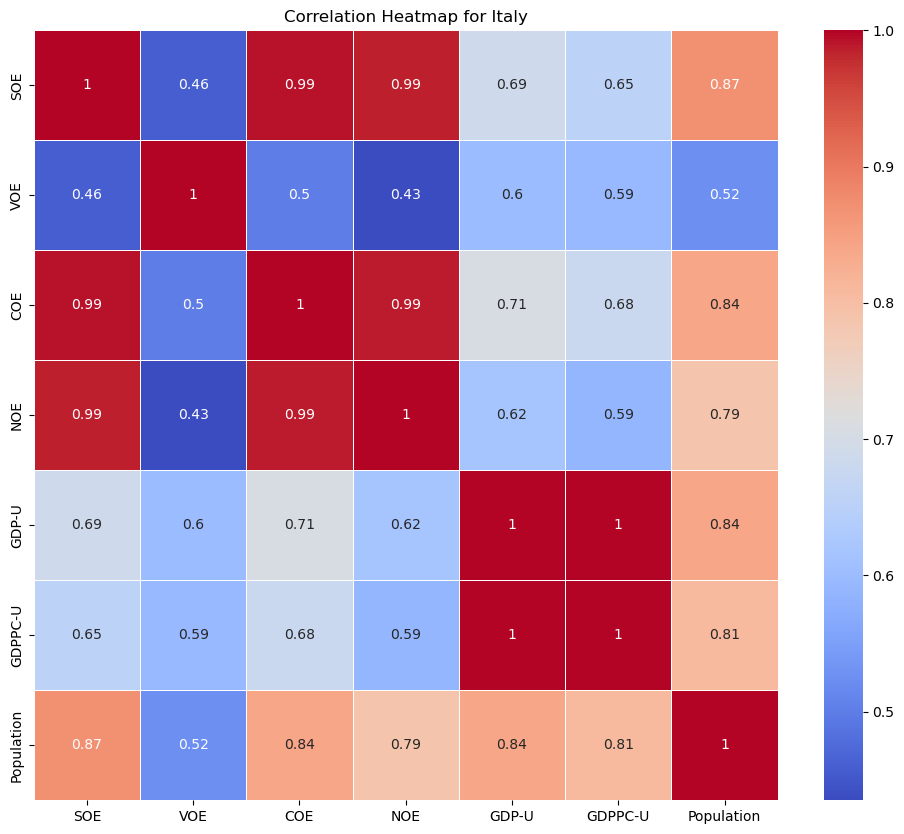

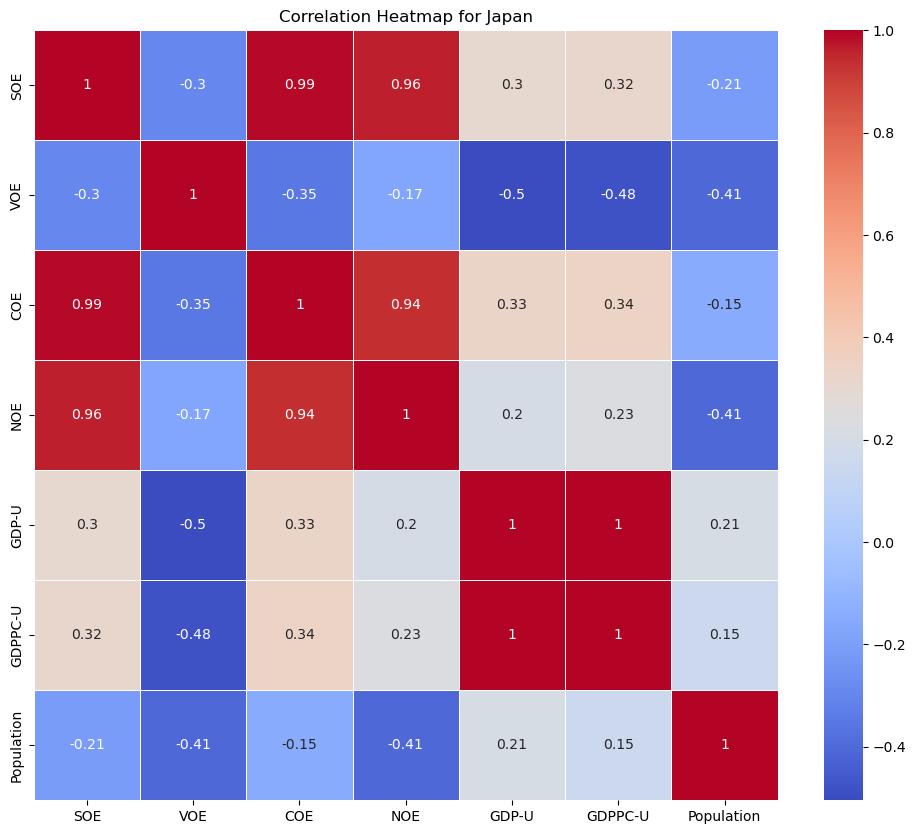

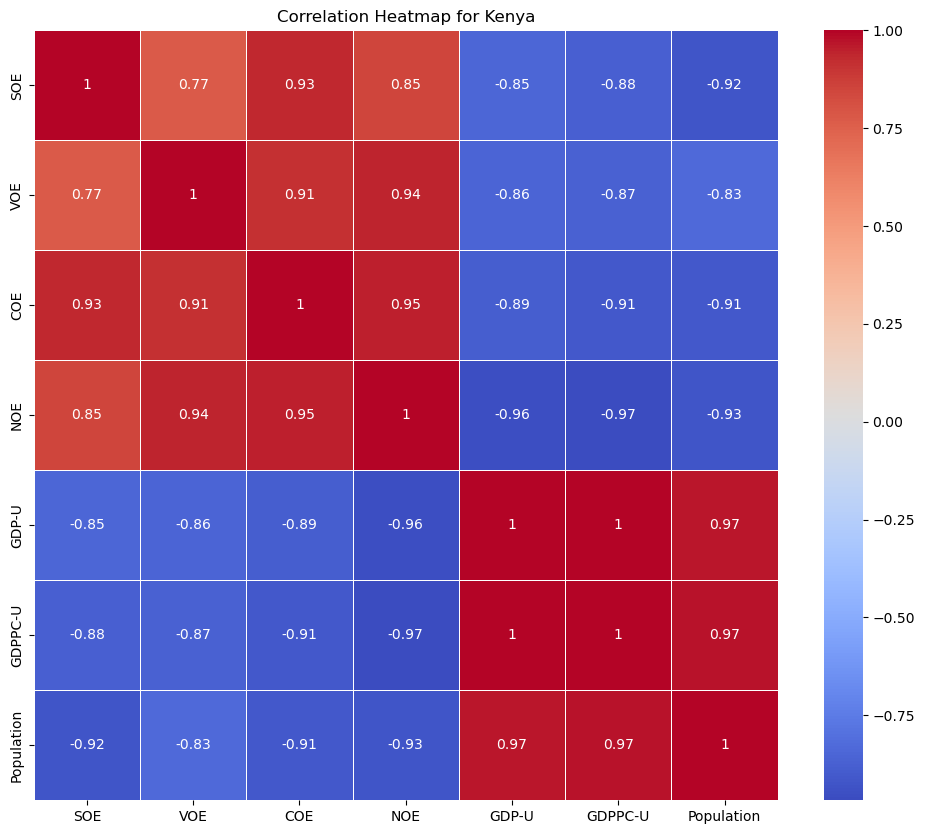

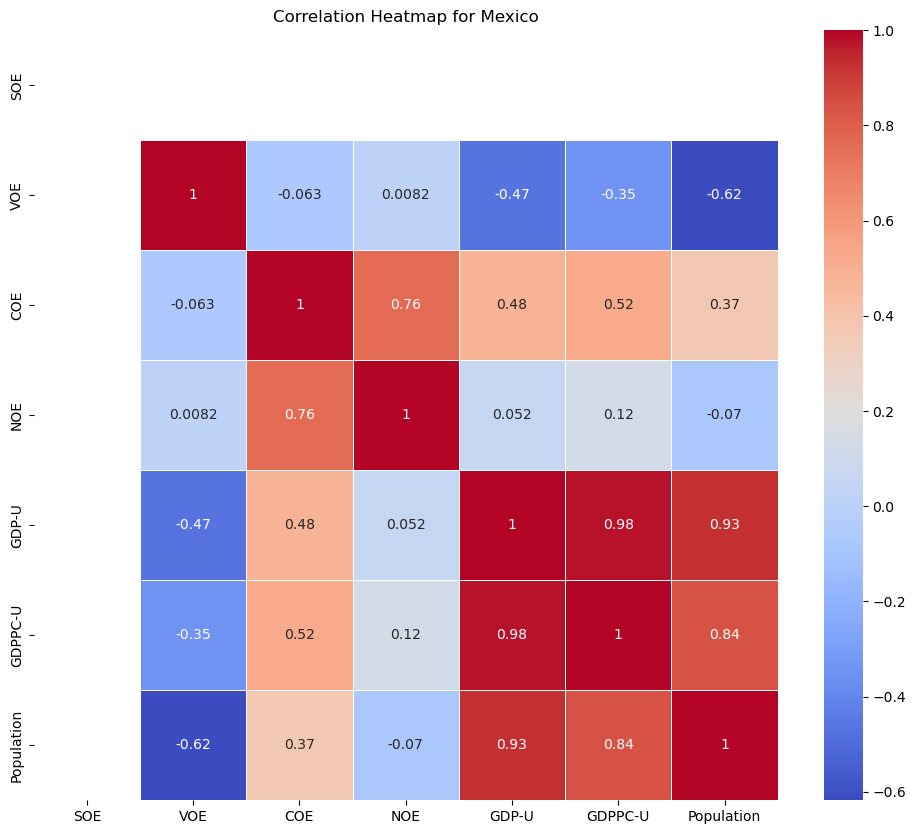

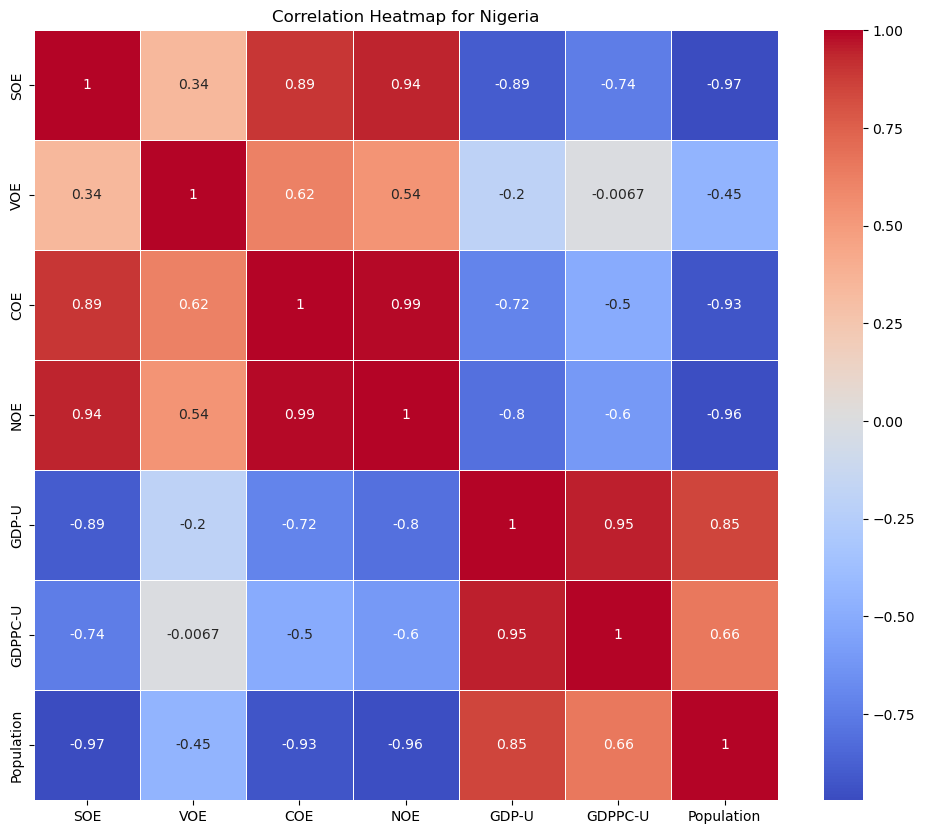

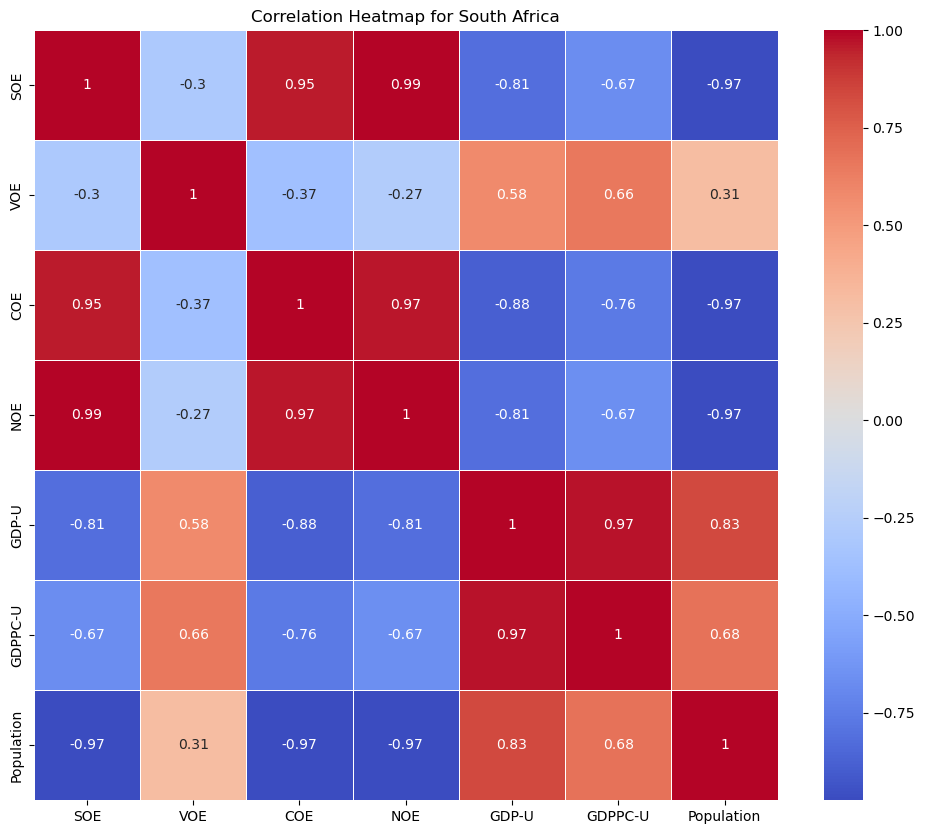

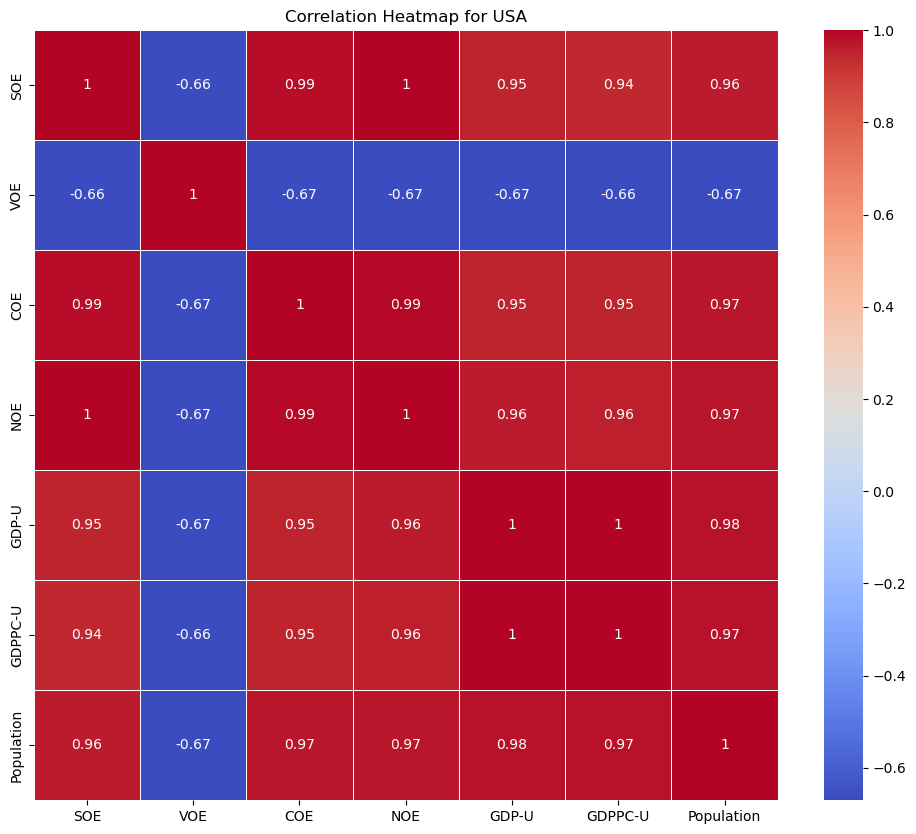

In [49]:
grouped_by_country = merged_data.groupby("country")

selected_columns = ['SOE', 'VOE', 'COE', 'NOE',
                    'GDP-U','GDPPC-U', 'Population']

for country, group in grouped_by_country:
    numeric_data = group[selected_columns]
    correlation_matrix = numeric_data.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(f'Correlation Heatmap for {country}')
    plt.show()


In [51]:
def calculate_correlation_by_country(data, country, weo_col, indicator_col):
    country_data = data[data["country"] == country]
    correlation, _ = pearsonr(country_data[weo_col], country_data[indicator_col])
    return correlation

correlations = []

for country in merged_data["country"].unique():
    correlation = calculate_correlation_by_country(merged_data, country, "GDP-N", "CDA")
    correlations.append({"country": country, "correlation": correlation})

correlations_df = pd.DataFrame(correlations)
correlations_df 

country  correlation
0      Argentina         0.32
1      Australia         0.89
2         Brazil         0.57
3         Canada         0.36
4          China         0.24
5        Denmark         0.90
6        Finland         0.73
7         France         0.69
8        Germany        -0.46
9          India        -0.26
10         Italy         0.08
11         Japan         0.74
12         Kenya        -0.06
13        Mexico         0.88
14       Nigeria        -0.45
15  South Africa         0.68
16           USA         0.82